# Imports

In [1]:
import os
import json
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
from transformers import BertTokenizer, BertModel
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import functional as F
import bz2
import nltk
import re
import torch.optim as optim
import torch.nn as nn
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import random
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
random.seed(42)

/home/rize/.conda/envs/deep/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rize/.conda/envs/deep/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /sise/home/rize/.conda/envs/deep/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/rize/.conda/envs/deep/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /sise/home/rize/.conda/envs/deep/lib/python3.10/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn

In [2]:
# Paths to directories (update these paths as necessary)
root_dir = '/home/rize/deep_assignments/NLP'

# Extract Data

In [ ]:
# Extract and save the decompressed content to a new file
# with bz2.open('heldout_op_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open('heldout_op_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# with bz2.open('train_op_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open('train_op_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# with bz2.open(f'{root_dir}/pair_task/heldout_pair_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open(f'{root_dir}/pair_task/heldout_pair_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# with bz2.open(f'{root_dir}/pair_task/train_pair_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open(f'{root_dir}/pair_task/train_pair_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# with bz2.open(f'{root_dir}/all/heldout_period_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open(f'{root_dir}/all/heldout_period_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# with bz2.open(f'{root_dir}/all/train_period_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open(f'{root_dir}/all/train_period_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# EDA

### Analyze op data set (original post)

- delta_label" shows whether the OP changed her opinion (True if she changed her mind, False if not).

- "selftext" and "title" provide textual information

- "name" is an identifier that can be used to find more submission-related information in the corresponding file in all/.

In [ ]:
# Create Combined DataFrames
test_df = pd.read_json('heldout_period_data.jsonlist', lines=True)
train_df = pd.read_json('train_period_data.jsonlist', lines=True)
combined_df = pd.concat([test_df, train_df])

KeyboardInterrupt: 

In [ ]:
op_test_df = pd.read_json('heldout_op_data.jsonlist', lines=True)
op_train_df = pd.read_json('train_op_data.jsonlist', lines=True)
op_combined_df = pd.concat([op_test_df, op_train_df])

In [ ]:
# pair_test_df = pd.read_json('heldout_pair_data.jsonlist', lines=True)
# pair_train_df = pd.read_json('train_pair_data.jsonlist', lines=True)
# pair_combined_df = pd.concat([pair_test_df, pair_train_df])

In [ ]:
op_combined_df.info()

In [ ]:
op_combined_df.head()

In [ ]:
print('Proportion of persuasion')
op_combined_df['delta_label'].value_counts(normalize=True)

In [ ]:
sns.countplot(x='delta_label', data=op_combined_df)
plt.title('Count of persuasion')
plt.show()

In [ ]:
print('Number of different authors: ', op_combined_df['name'].nunique())

In [ ]:
# Function to calculate average token count with and without stop words for a DataFrame column
def calculate_avg_tokens_column(df, column_name):
    stop_words = set(stopwords.words('english'))

    token_counts_with_stopwords = []
    token_counts_without_stopwords = []

    for text in df[column_name].dropna():
        if isinstance(text, str):  # Ensure the value is a valid string
            tokens = word_tokenize(text.lower())  # Tokenize and lowercase the text
            tokens_without_stopwords = [token for token in tokens if token not in stop_words]

            token_counts_with_stopwords.append(len(tokens))
            token_counts_without_stopwords.append(len(tokens_without_stopwords))

    # Calculate the averages
    avg_with_stopwords = sum(token_counts_with_stopwords) / len(token_counts_with_stopwords)
    avg_without_stopwords = sum(token_counts_without_stopwords) / len(token_counts_without_stopwords)

    return avg_with_stopwords, avg_without_stopwords

# Perform the analysis on the 'op_title' column of the DataFrame
avg_with_stopwords_title, avg_without_stopwords_title = calculate_avg_tokens_column(op_combined_df, 'selftext')

print(f"Average token count with stop words in 'selftext': {avg_with_stopwords_title}")
print(f"Average token count without stop words in 'selftext': {avg_without_stopwords_title}")

### Analyze Pair data

- "positive" is a list of replies in a rooted path-unit that won a delta from OP, while "negative" is a matching rooted path-unit that did not win a delta.

- "op_author", "op_text", and "op_title" give information for the original post.

- "op_name" is an identifier that can be used to find more submission-related information in the corresponding file in all/.

In [10]:
# Load data set
pair_test_df = pd.read_json(f'{root_dir}/pair_task/heldout_pair_data.jsonlist', lines=True)
pair_train_df = pd.read_json(f'{root_dir}/pair_task/train_pair_data.jsonlist', lines=True)
pair_combined_df = pd.concat([pair_test_df, pair_train_df])

In [ ]:
pair_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4263 entries, 0 to 3455
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   op_author  4263 non-null   object
 1   op_text    4263 non-null   object
 2   op_title   4263 non-null   object
 3   positive   4263 non-null   object
 4   negative   4263 non-null   object
 5   op_name    4263 non-null   object
dtypes: object(6)
memory usage: 233.1+ KB


In [ ]:
pair_combined_df.head()

,op_author,op_text,op_title,positive,negative,op_name
0,923iwek,I'll start off by saying I'm a vegetarian and ...,CMV: The contribution of vegans/vegetarians an...,"{'ancestor': 't1_cundk5r', 'author': 'ghoooooo...","{'ancestor': 't1_cunbl8g', 'author': 'ClimateM...",t3_3j8yfq
1,923iwek,I'll start off by saying I'm a vegetarian and ...,CMV: The contribution of vegans/vegetarians an...,"{'ancestor': 't1_cunbkbz', 'author': 'archagon...","{'ancestor': 't1_cuncrke', 'author': 'Diomange...",t3_3j8yfq
2,Navyurf,"Hello, I'm Luke and for the longest time a sma...",CMV:I want to live in Scandinavia,"{'ancestor': 't1_cun0c3t', 'author': 'huadpe',...","{'ancestor': 't1_cun2oqr', 'author': 'iamambie...",t3_3j7dlx
3,trashlunch,"By ""practical reason,"" I mean a reason that mo...",CMV: There is no practical reason for any indi...,"{'ancestor': 't1_cumn3j4', 'author': 'ReOsIr10...","{'ancestor': 't1_cumqh8n', 'author': 'Omega037...",t3_3j64aa
4,VaginalExcrement,"\n_____\n\nAlright, so, i was challenged by a ...",CMV: We Should execute the weak to improve the...,"{'ancestor': 't1_cumhf65', 'author': 'BadKeyMa...","{'ancestor': 't1_cumi9vr', 'author': 'MCBeatho...",t3_3j5b7g


In [ ]:
pair_combined_df.iloc[2]['positive']['comments'][0]['id']

'cun0c3t'

Fields are identical for negative and positive, Interesting fields for each comment are:
- Score, up, and down metrics reflecting the comment's popularity and reception.
- controversiality, A score representing how divisive the comment is.
- body, The text content of the comment.

In [ ]:
print('Number of different OP authors: ', pair_combined_df['op_author'].nunique())
print('Number of original post per author: ')
pair_combined_df.groupby('op_author').size().describe()

Number of different OP authors:  2619
Number of original post per author: 


,0
count,2619.000000
mean,1.627721
std,1.285167
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,19.000000


In [ ]:
pair_combined_df.shape

(4263, 6)

In [ ]:

# Function to add new fields for the number of positive and negative comments
def add_comment_counts_json(df, positive_col, negative_col):
    num_positive = []
    num_negative = []

    for _, row in df.iterrows():
        try:
            # Access the 'comments' key directly from the dictionary
            positive_data = row[positive_col]
            negative_data = row[negative_col]

            # Count the number of comments
            num_positive.append(len(positive_data.get('comments', [])))
            num_negative.append(len(negative_data.get('comments', [])))
        except (json.JSONDecodeError, KeyError, TypeError):
            # Handle parsing errors or missing fields
            num_positive.append(0)
            num_negative.append(0)

    # Add the new columns to the DataFrame
    df['num_of_positive'] = num_positive
    df['num_of_negative'] = num_negative
    return df

# Add the new fields to the dataset
pair_data = add_comment_counts_json(pair_combined_df, 'positive', 'negative')

pair_data[['num_of_positive', 'num_of_negative']].describe()

,num_of_positive,num_of_negative
count,4263.000000,4263.000000
mean,1.422003,1.291344
std,0.747248,0.690852
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,5.000000,5.000000


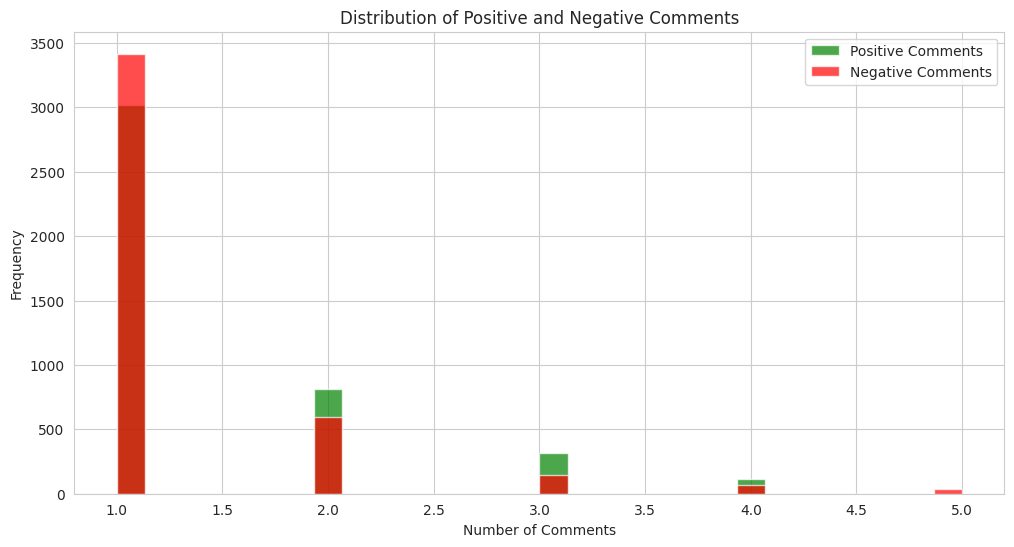

In [ ]:
# Plot the distribution of positive and negative comments
plt.figure(figsize=(12, 6))

# Distribution for positive comments
plt.hist(pair_data['num_of_positive'], bins=30, alpha=0.7, label='Positive Comments', color='green')

# Distribution for negative comments
plt.hist(pair_data['num_of_negative'], bins=30, alpha=0.7, label='Negative Comments', color='red')

# Add labels and title
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.title('Distribution of Positive and Negative Comments')
plt.legend()
plt.show()

In [ ]:
print('Example of discussion with title')
pair_combined_df.iloc[0]['op_title']

Example of discussion with title


'CMV: The contribution of vegans/vegetarians and other environmentally conscious people is absolutely insignificant.'

In [ ]:
print('Positive Example:')
pair_combined_df.iloc[0]['positive']['comments'][0]['body']

Positive Example:


'In short, the reality is: It adds up.\n\n[Does Veganism Make a Difference?](http://www.animalliberationfront.com/Philosophy/Utilitarianism/Does%20Veganism%20Make%20a%20Difference.htm)\n\n[Expected Utility, Contributory Causation, and Vegetarianism](http://www.veganoutreach.org/enewsletter/thresholds.pdf)\n\nBoth of these essays approach your question in a statistics-based manner that focuses on thresholds. They propose that your effect on meat production is a measurable probability.\n\nIn other words, they ask questions like, "What are the odds that your purchase of, say, a frozen turkey will be the one that causes your grocery store to order another entire shipment of frozen turkeys? And that that shipment causes the food distributor to order more turkeys? And that that shipment causes a farm to slaughter more turkeys?" \n\nThe number of animals produced and slaughtered is so high that the very small probability of you sparing an animal from it still translates to 50-100 animals per 

In [ ]:
print('Negative Example:')
pair_combined_df.iloc[0]['negative']['comments'][0]['body']

Negative Example:


"I agree with /u/huadpe that simply the act of being vegetarian/vegan makes it easier for other people to reduce their meat consumption, because as the population of vegetarians and vegans expands, restaurants are offering more and better vegetarian/vegan options, including some that are so tasty only the most rabid carnivores would turn their nose up at them. The growing number of people with vegetarian/vegan friends and family members also means that more people are being exposed to delicious vegetarian/vegan food and even learning how to cook it, all of which chips away at the all-too-common notion that any meal without meat isn't worth eating.\n\nHelping society at large reduce its meat consumption is really important because meat production has such an enormous environmental impact, especially with regard to climate change. The exact contribution of animal agriculture to climate change is disputed, but the most widely accepted statistics seem to put animal agriculture at about 15-

### Analyze period data (all data raw from reddit API)

In [ ]:
test_df.head()

,domain,banned_by,media_embed,subreddit,selftext_html,selftext,likes,suggested_sort,user_reports,secure_media,...,url,author_flair_text,quarantine,title,created_utc,distinguished,mod_reports,visited,num_reports,ups
0,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","From what I understand, the only significant d...",NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,1∆,False,CMV: The position of Vice President of the Uni...,1441131871,None,[],False,NaN,0
1,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",I'll start off by saying I'm a vegetarian and ...,NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,CMV: The contribution of vegans/vegetarians an...,1441130982,None,[],False,NaN,326
2,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",Al Franken went on Jon Stewart [a few weeks ag...,NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,CMV: Anti-discrimination law is discriminatory.,1441126567,None,[],False,NaN,23
3,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","I'll be honest with you, I didn't even know ab...",NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,"CMV: Nicki Minaj is in the wrong, not Miley.",1441121901,None,[],False,NaN,0
4,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",(Note: While this post is written from the poi...,NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,"CMV: On online dating, if you don't want to ta...",1441120965,None,[],False,NaN,0


In [ ]:
test_df[['id', 'comments', 'author_flair_text']].head()

,id,comments,author_flair_text
0,3j90qv,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",1∆
1,3j8yfq,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None
2,3j8n34,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None
3,3j8bhs,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None
4,3j895i,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None


author_flair_text = Delta

In [ ]:
test_df.iloc[0]['comments'][0]

{'subreddit_id': 't5_2w2s8',
 'banned_by': None,
 'removal_reason': None,
 'link_id': 't3_3j90qv',
 'likes': None,
 'replies': {'kind': 'Listing',
  'data': {'modhash': '',
   'children': ['cunbngs'],
   'after': None,
   'before': None}},
 'user_reports': [],
 'saved': False,
 'id': 'cun9x23',
 'gilded': 0,
 'archived': False,
 'report_reasons': None,
 'author': 'draculabakula',
 'parent_id': 't3_3j90qv',
 'score': 1,
 'approved_by': None,
 'controversiality': 0,
 'body': 'The vice president often is called to act as a replacement for a duty or appearance if the president is not around. For instance, meeting foreign dignitaries if the president is out of town. There needs to be a second face of the executive branch.\n\nAlso, if the second in succession to the presidency was the speaker of the house, the opposing party might take it upon themselves to try and assassinate or impeach the president simply for the reason of taking over the executive branch. The position of vice president e

We can parse and build conversion tree for each post, usig the comments parent id.

# Preprocessing

In [3]:
# Step 1: Preprocessing - Load and Parse Data
def load_jsonlines(file_path):
    """Load data from a .jsonlist file."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

In [4]:
pair_test_df = pd.read_json(f'{root_dir}/CMv data/pair_task/heldout_pair_data.jsonlist', lines=True)
pair_train_df = pd.read_json(f'{root_dir}/CMv data/pair_task/train_pair_data.jsonlist', lines=True)
pair_combined_df = pd.concat([pair_test_df, pair_train_df])

train_period_data = load_jsonlines(f"{root_dir}/CMv data/all/train_period_data.jsonlist")
heldout_period_data = load_jsonlines(f"{root_dir}/CMv data/all/heldout_period_data.jsonlist")

print(f"Size of all train data: {len(train_period_data)}, size of all test data: {len(heldout_period_data)}")
print(f"Size of pair train data: {len(pair_train_df)}, size of pair test data: {len(pair_test_df)}")

Size of all train data: 18363, size of all test data: 2263
Size of pair train data: 3456, size of pair test data: 807


In [5]:
def clean_selftext(text):
    """
    Remove the CMV rules section from the selftext field.
    """
    return text.split('*Hello, users of CMV!')[0]

# Step 2: Preprocessing - Extract Relevant Features
def preprocess_data(data):
    """Extract and clean relevant data."""
    processed_data = []
    for entry in data:
        submission = {
            "id": entry["id"],
            "name": entry["name"],
            "author": entry["author"],
            "author_flair_text": entry["author_flair_text"], # General number of deltas got in the CMV subreddit
            "ups": entry["ups"],
            "downs": entry["downs"],
            "num_comments": entry["num_comments"],
            "body": clean_selftext(entry["selftext"]),
            "title": entry["title"],
            "comments": entry['comments'],
        }
        processed_data.append(submission)
    return processed_data

In [6]:
train_processed = preprocess_data(train_period_data)
test_processed = preprocess_data(heldout_period_data)
len(train_processed), len(test_processed)

(18363, 2263)

In [7]:
# Extract positive and negative comment IDs from pair data
positive_comment_ids = set()
negative_comment_ids = set()
for _, row in pair_combined_df[['positive', 'negative']].iterrows():  # Iterate through rows
    positives = row['positive']  # Access 'positive' column
    negatives = row['negative']  # Access 'negative' column
    for comment in positives["comments"]:
        positive_comment_ids.add(comment["id"])
    for comment in negatives["comments"]:
        negative_comment_ids.add(comment["id"])

len(positive_comment_ids), len(negative_comment_ids)

(6030, 4990)

In [8]:
pair_combined_df.iloc[0]

op_author                                              923iwek
op_text      I'll start off by saying I'm a vegetarian and ...
op_title     CMV: The contribution of vegans/vegetarians an...
positive     {'ancestor': 't1_cundk5r', 'author': 'ghoooooo...
negative     {'ancestor': 't1_cunbl8g', 'author': 'ClimateM...
op_name                                              t3_3j8yfq
Name: 0, dtype: object

In [8]:
# Add delta label to all comments
all_comments = {}
op_names_set = set(pair_combined_df['op_name'])

for i, submission in enumerate(train_processed):
    if submission['name'] in op_names_set:
        all_comments[submission['id']] = submission
        all_comments[submission['id']]["delta"] = 0 

        for comment in submission["comments"]:
            comment_id = comment["id"]
            if comment_id not in all_comments:  # Avoid overwrites
                all_comments[comment_id] = comment
            # Assign delta label
            all_comments[comment_id]["delta"] = 1 if comment_id in positive_comment_ids else 0

for submission in test_processed:
    if submission['name'] in op_names_set:
        all_comments[submission['id']] = submission
        all_comments[submission['id']]["delta"] = 0 
        for comment in submission["comments"]:
            comment_id = comment["id"]
            if comment_id not in all_comments:  # Avoid overwrites
                all_comments[comment_id] = comment
            # Assign delta label
            all_comments[comment_id]["delta"] = 1 if comment_id in positive_comment_ids else 0

# Count labeled and unlabeled comments
delta_count = sum(comment["delta"] == 1 for comment in all_comments.values())
no_delta_count = sum(comment["delta"] == 0 for comment in all_comments.values())

print(f"Comments with delta: {delta_count}")
print(f"Comments without delta: {no_delta_count}")
print('Positive class ratio: ', delta_count / (delta_count + no_delta_count))

Comments with delta: 6030
Comments without delta: 287267
Positive class ratio:  0.02055936473949614


In [9]:
# Take only the graphs that has at least one delta in the comments
train_processed_reduced = [submission for submission in train_processed if submission['name'] in op_names_set]
test_processed_reduced = [submission for submission in test_processed if submission['name'] in op_names_set]

# Output the lengths of the filtered lists
len_train = len(train_processed_reduced)
len_test = len(test_processed_reduced)

print(f"Length of reduced train_processed: {len_train}")
print(f"Length of reduced test_processed: {len_test}")


Length of reduced train_processed: 2509
Length of reduced test_processed: 542


# Graph Construction

In [10]:
# Graph Construction
def standardize_node_id(node_id):
    """Remove Reddit-specific prefixes (t1_, t3_) from node IDs."""
    return node_id.split("_")[-1]

def build_basic_graph(root, comments, comment_to_include=None, all_edges=False, filter_distance=1):
    """Build a conversation tree graph where each parent points to all its descendants."""
    graph = nx.DiGraph()
    
    # Filter comments and add the root node
    comment_ids, root_id, root_author, root_body = initialize_graph(graph, root, comments)

    # Add comment nodes and direct parent-child edges
    delta_nodes = add_nodes_and_edges(graph, comments, root_id, root_author, root_body, comment_ids, comment_to_include)

    # Calculate distances from root to delta nodes
    delta_distances = calculate_delta_distances(graph, root_id, delta_nodes)

    # Add all descendant edges if specified
    if all_edges:
        add_descendant_edges(graph, root_id)
        add_longest_path_from_root(graph, root_id, filter_distance)
        
    # Update root node attributes
    update_root_node_attributes(graph, root_id, delta_nodes, delta_distances)

    return graph


def initialize_graph(graph, root, comments):
    """Initialize the graph by adding the root node and filtering comments."""
    comment_ids = {
        standardize_node_id(comment["id"]) for comment in comments if "author" not in comment or comment["author"] != 'DeltaBot'
    }
    root_id = standardize_node_id(root["id"])
    root_author = root.get("author", "Unknown")
    root_body = root.get("body", "")
    
    graph.add_node(
        root_id,
        text=root.get("body", ""),
        delta=0,
        root_id=root_id,
        root_body=root_body,
        author=root_author,
        ups=root.get("ups", 0),
        downs=root.get("downs", 0),
        mask=1,
        author_flair_text=root.get("author_flair_text", 0),
        distance_to_op=0,
        delta_count=0,  # Initialize delta count
        delta_distances=[],  # Initialize list for distances to delta nodes
    )
    comment_ids.add(root_id)

    return comment_ids, root_id, root_author, root_body

def add_nodes_and_edges(graph, comments, root_id, root_author, root_body, comment_ids, comment_to_include=None):
    """Add nodes and direct parent-child edges to the graph."""
    delta_nodes = []
    
    for comment in comments:
        # Standardize node IDs
        node_id = standardize_node_id(comment["id"])
        parent_id = standardize_node_id(comment.get("parent_id", ""))
        
        # Skip DeltaBot comments
        if node_id not in comment_ids:
            continue

        # Add the current comment as a node
        comment_author = comment.get("author", "Unknown")
        delta_value = comment.get("delta", 0)

        # Check if the comment should be masked
        if (comment_to_include and node_id not in comment_to_include) or comment_author == root_author:
            mask_node = 1
        else:
            mask_node = 0

        graph.add_node(
            node_id,
            text=comment.get("body", ""),
            delta=delta_value,
            root_id=root_id,
            root_body=root_body,
            author=comment_author,
            ups=comment.get("ups", 0),
            downs=comment.get("downs", 0),
            mask=mask_node, # mask nodes that are not in the comment_to_include list
            author_flair_text=comment.get("author_flair_text", 0),
        )

        # Track delta nodes
        if delta_value == 1:
            delta_nodes.append(node_id)

        # Add direct parent-child edge with distance = 1
        if parent_id and parent_id in comment_ids:
            graph.add_edge(parent_id, node_id, distance=1)
    
    return delta_nodes

def calculate_delta_distances(graph, root_id, delta_nodes):
    """Calculate the distances from the root node to delta nodes."""
    delta_distances = []
    for delta_node in delta_nodes:
        try:
            distance = nx.shortest_path_length(graph, source=root_id, target=delta_node)
            delta_distances.append(distance)
        except nx.NetworkXNoPath:
            pass  # Skip if no path exists
    return delta_distances

def add_descendant_edges(graph, root_id):
    """Add edges from each node to all its descendants."""
    for node in list(graph.nodes):
        descendants = nx.descendants(graph, node)  # Get all descendants
        for descendant in descendants:
            if not graph.has_edge(node, descendant):  # Avoid duplicate edges
                distance = nx.shortest_path_length(graph, source=node, target=descendant)
                graph.add_edge(node, descendant, distance=distance)  # Add distance as an attribute

def add_longest_path_from_root(graph, root_id, filter_distance=1):
    """
    Compute the longest path from the root node to every other node in the graph.
    Assumes that each node has direct edges to its descendants.
    """
    # Initialize the longest path dictionary
    longest_path_distances = {node: float("-inf") for node in graph.nodes}
    longest_path_distances[root_id] = 0  # Distance to root is 0

    # Perform topological sort for proper traversal order
    try:
        topo_sort = list(nx.topological_sort(graph))
    except nx.NetworkXUnfeasible:
        raise ValueError("Graph must be a DAG to compute longest paths.")

    # Traverse in topological order to compute the longest path
    for node in topo_sort:
        for _, descendant, edge_data in graph.out_edges(node, data=True):
            distance = edge_data.get("distance", 1)  # Default to 1 if no distance attribute
            # Update the longest path distance if a longer path is found
            longest_path_distances[descendant] = max(
                longest_path_distances[descendant],
                longest_path_distances[node] + distance
            )

    # Add the longest path distance as a node attribute
    for node, longest_distance in longest_path_distances.items():
        graph.nodes[node]["distance_to_op"] = longest_distance
        # Mask nodes that are beyond the filter distance
        if longest_distance < filter_distance:
            graph.nodes[node]["mask"] = 1

    return graph

def update_root_node_attributes(graph, root_id, delta_nodes, delta_distances):
    """Update the root node with delta count and distances."""
    graph.nodes[root_id]["delta_count"] = len(delta_nodes)
    graph.nodes[root_id]["delta_distances"] = delta_distances

In [11]:
def generate_color_map(authors):
    """Generate a unique color for each author."""
    colors = itertools.cycle(["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta", "yellow", "black", "silver", "gold", "lime", "teal"])
    return {author: next(colors) for author in authors}

def visualize_graph_with_author_colors_and_labels(graph, figsize=(12, 8), title='Conversation Graph with Author Colors and Labels'):
    """Visualize the conversation graph with different colors for each author and custom labels."""
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph)  # Layout algorithm for positioning nodes

    # Extract all unique authors from the graph
    authors = {data["author"] for _, data in graph.nodes(data=True)}

    # Generate a color map for authors
    color_map = generate_color_map(authors)
    # Determine node colors based on the author
    node_colors = [color_map[data["author"]] for _, data in graph.nodes(data=True)]

    # Draw nodes with colors
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color=node_colors, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edge_color="gray", alpha=0.5)

    # Create custom labels
    labels = {}
    for node, data in graph.nodes(data=True):
        if data.get("delta", 0):  # Add delta sign for nodes with deltas
            labels[node] = "∆"
        elif data["root_id"] == node:  # Display root text for the root node
            labels[node] = "Root"  # Truncated root text
        else:
            labels[node] = data['distance_to_op']  # No label for other nodes

    # Draw labels
    nx.draw_networkx_labels(graph, pos, labels, font_size=8, font_color="black")

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

def plot_distance_to_op_distribution(train_graphs, test_graphs, node_id_set, title="Distance to OP Distribution"):
    """
    Plot the distribution of `distance_to_op` for nodes in a given set of node IDs, side by side for train and test sets.
    Args:
        train_graphs (list): List of NetworkX graphs for the train set.
        test_graphs (list): List of NetworkX graphs for the test set.
        node_id_set (set): Set of node IDs to include in the plot.
        title (str): Title of the plot.
    """
    # Extract `distance_to_op` for nodes in the provided set
    train_distances = [
        graph.nodes[node]["distance_to_op"]
        for graph in train_graphs
        for node in graph.nodes
        if node in node_id_set and "distance_to_op" in graph.nodes[node]
    ]
    test_distances = [
        graph.nodes[node]["distance_to_op"]
        for graph in test_graphs
        for node in graph.nodes
        if node in node_id_set and "distance_to_op" in graph.nodes[node]
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_distances, bins=20, color="skyblue", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Distance to OP")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_distances, bins=20, color="orange", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Distance to OP")

    # Adjust layout and show
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_delta_distribution(train_graphs, test_graphs):
    """
    Plot the distribution of the number of deltas in each graph for train and test sets.
    """
    # Extract delta counts for train and test graphs
    train_delta_counts = [
        graph.nodes[root]["delta_count"]
        for graph in train_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
    ]
    test_delta_counts = [
        graph.nodes[root]["delta_count"]
        for graph in test_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_delta_counts, bins=20, color="skyblue", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Number of Deltas")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_delta_counts, bins=20, color="lightcoral", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Number of Deltas")

    # Adjust layout and show
    plt.suptitle("Distribution of Delta Counts per Graph")
    plt.tight_layout()
    plt.show()

def plot_delta_distance_distribution(train_graphs, test_graphs):
    """
    Plot the distribution of distances to delta nodes for train and test sets.
    """
    # Extract delta distances for train and test graphs
    train_delta_distances = [
        distance
        for graph in train_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
        for distance in graph.nodes[root]["delta_distances"]
    ]
    test_delta_distances = [
        distance
        for graph in test_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
        for distance in graph.nodes[root]["delta_distances"]
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_delta_distances, bins=20, color="lightgreen", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Distance to Delta Node")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_delta_distances, bins=20, color="gold", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Distance to Delta Node")

    # Adjust layout and show
    plt.suptitle("Distribution of Distances to Delta Nodes from Root")
    plt.tight_layout()
    plt.show()

def plot_edge_distance_distribution(train_graphs, test_graphs):
    """
    Plot the distribution of edge distances for train and test sets.
    """
    # Extract edge distances for train and test graphs
    train_edge_distances = [
        graph.edges[edge]["distance"]
        for graph in train_graphs
        for edge in graph.edges
        if "distance" in graph.edges[edge]  # Ensure distance attribute exists
    ]
    test_edge_distances = [
        graph.edges[edge]["distance"]
        for graph in test_graphs
        for edge in graph.edges
        if "distance" in graph.edges[edge]  # Ensure distance attribute exists
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_edge_distances, bins=20, color="orange", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Edge Distance")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_edge_distances, bins=20, color="purple", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Edge Distance")

    # Adjust layout and show
    plt.suptitle("Distribution of Edge Distances")
    plt.tight_layout()
    plt.show()


Nodes Example graph with edges from parent to all it descendants: ['2ro9ux', 'cnhplrm', 'cnhrvq7', 'cnhz66d', 'cniauhy', 'cnibfev', 'cnhpsmr', 'cnhpvqs', 'cnhq7iw', 'cnhqrw1', 'cnhqzsf', 'cni8tcx', 'cnhpp4o', 'cnhqouu', 'cnhrd8u', 'cnhrwsq', 'cnhs6sc', 'cnhtr4t', 'cnhuopi', 'cnio1bg', 'cnhq330', 'cnhs7xb', 'cnhpnmr', 'cnhqhxa', 'cnhrkoc', 'cnhq7nv', 'cnhqcwz', 'cnhsyft', 'cnhww76', 'cnhz5wq', 'cni80dr', 'cni8e2y']
Edges Example graph with edges from parent to all it descendants: [('2ro9ux', 'cnhplrm'), ('2ro9ux', 'cnhpp4o'), ('2ro9ux', 'cnhq330'), ('2ro9ux', 'cnhs7xb'), ('2ro9ux', 'cnhpnmr'), ('2ro9ux', 'cnhq7nv'), ('2ro9ux', 'cnhqcwz'), ('2ro9ux', 'cnhsyft'), ('2ro9ux', 'cnhww76'), ('2ro9ux', 'cnhz5wq'), ('2ro9ux', 'cni80dr'), ('2ro9ux', 'cni8e2y'), ('2ro9ux', 'cnhtr4t'), ('2ro9ux', 'cnhrvq7'), ('2ro9ux', 'cnhrkoc'), ('2ro9ux', 'cnhqhxa'), ('2ro9ux', 'cnhqzsf'), ('2ro9ux', 'cnhuopi'), ('2ro9ux', 'cni8tcx'), ('2ro9ux', 'cnhrd8u'), ('2ro9ux', 'cnibfev'), ('2ro9ux', 'cnhq7iw'), ('2ro9ux'

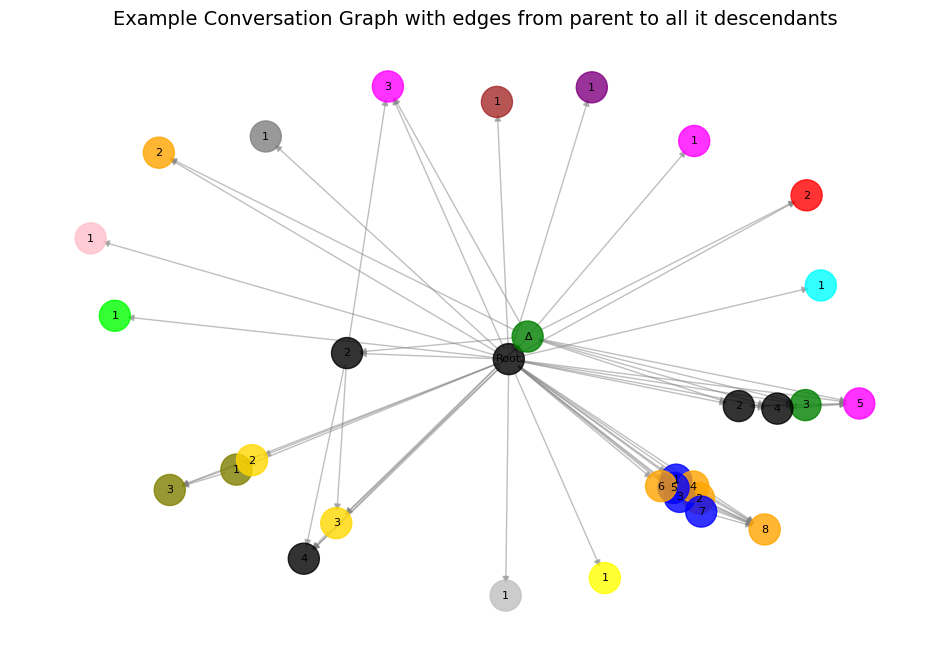

In [12]:
comment_to_include = negative_comment_ids | positive_comment_ids

# Example graph 
root = train_processed_reduced[0]
example_graph = build_basic_graph(root, train_processed_reduced[0]["comments"], all_edges=True) #comment_to_include=comment_to_include , filter_distance=3

print('Nodes Example graph with edges from parent to all it descendants:', example_graph.nodes())
print('Edges Example graph with edges from parent to all it descendants:', example_graph.edges())

visualize_graph_with_author_colors_and_labels(example_graph, title='Example Conversation Graph with edges from parent to all it descendants')

In [13]:
# Build graphs for all conversations in the training data
conversation_graphs_train = []
for record in tqdm(train_processed_reduced):
    conversation_graphs_train.append(build_basic_graph(record, record["comments"], all_edges=True)) #, comment_to_include=comment_to_include , filter_distance=3

# Build graphs for all conversations in the test data
conversation_graphs_test = []
for record in tqdm(test_processed_reduced):
    conversation_graphs_test.append(build_basic_graph(record, record["comments"], all_edges=True)) #, comment_to_include=comment_to_include , filter_distance=3

len(conversation_graphs_train), len(conversation_graphs_test)

100%|██████████| 542/542 [00:03<00:00, 162.65it/s]


(2509, 542)

In [14]:
import gc
# del all df to free up memory
del train_processed_reduced
del test_processed_reduced
del train_processed
del test_processed
del train_period_data
del heldout_period_data
del pair_train_df
del pair_test_df

gc.collect()

10552

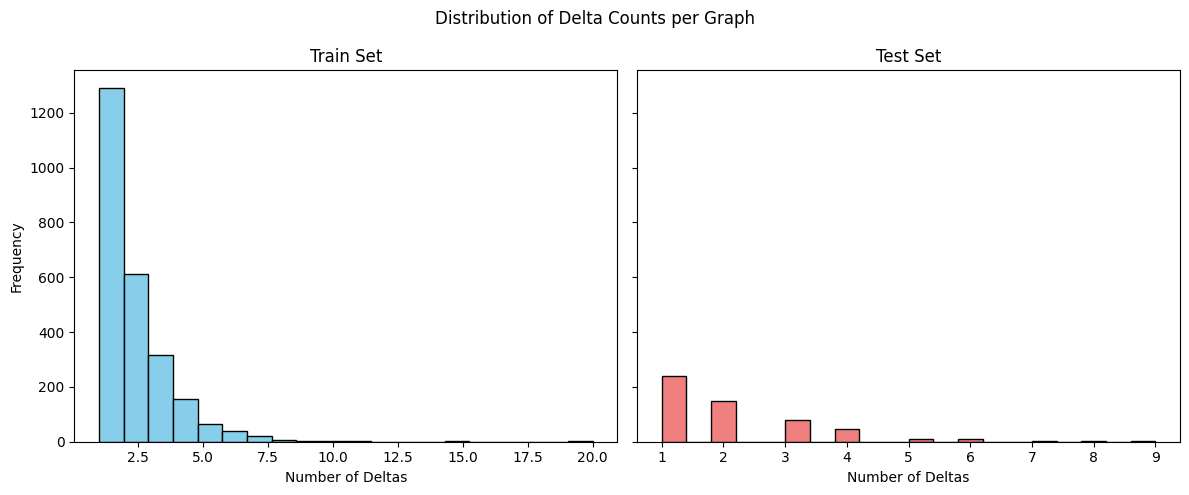

In [19]:
# Plot delta count distribution
plot_delta_distribution(conversation_graphs_train, conversation_graphs_test)

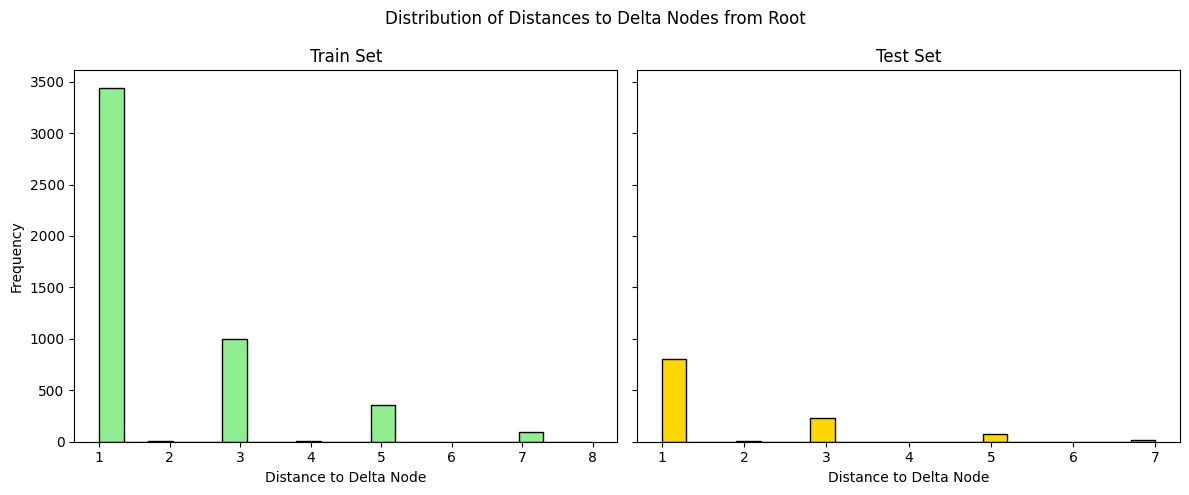

In [24]:
# Plot delta distance distribution
plot_delta_distance_distribution(conversation_graphs_train, conversation_graphs_test)

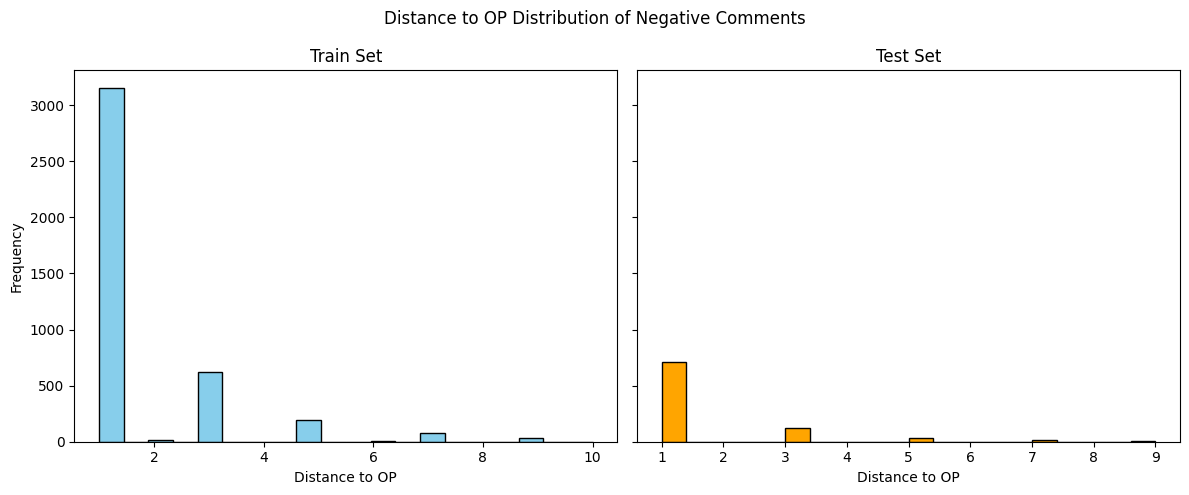

In [ ]:
plot_distance_to_op_distribution(conversation_graphs_train, conversation_graphs_test, negative_comment_ids, title="Distance to OP Distribution of Negative Comments")

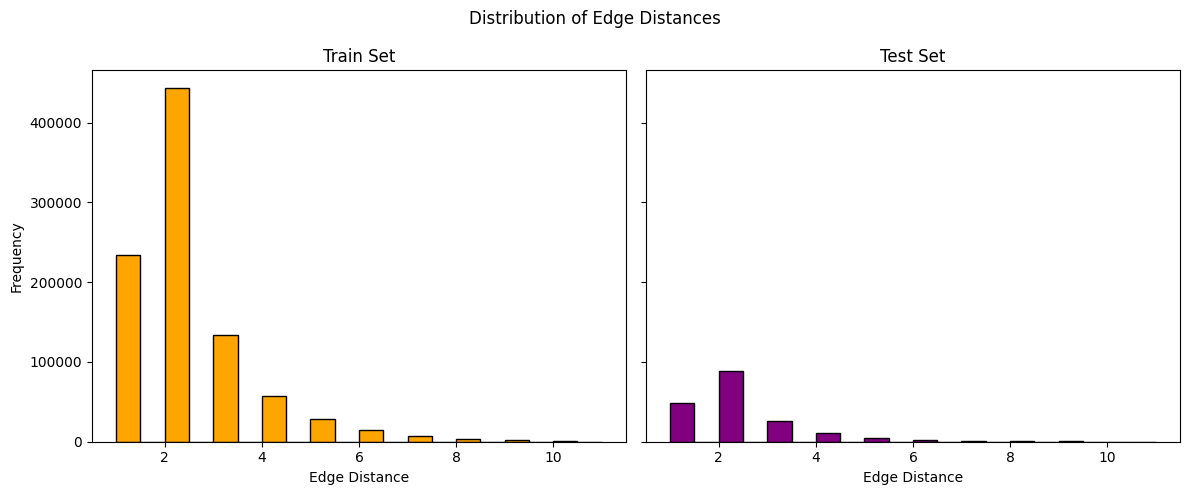

In [66]:
# Plot edge distance distribution
plot_edge_distance_distribution(conversation_graphs_train, conversation_graphs_test)

# Text Embedding + Data loaders

In [16]:
# # Feature Extraction - BERT Embeddings
# def generate_bert_embeddings(texts, tokenizer, model, device):
#     """Generate embeddings for a list of texts using BERT."""
#     inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1)

In [26]:
# # Load pre-trained BERT
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = BertModel.from_pretrained("bert-base-uncased")
# if torch.cuda.is_available():
#     print("Using CUDA")
#     device = torch.device("cuda")
# else:
#     print("Using CPU")
#     device = torch.device("cpu")
# bert_model = bert_model.to(device)

Using CUDA


In [21]:
# def build_node_to_idx(graphs):
#     """
#     Create a global mapping from node IDs to numerical indices.
#     """
#     node_to_idx = {}
#     idx = 0
#     for graph in graphs:
#         for node in graph.nodes:
#             if node not in node_to_idx:
#                 node_to_idx[node] = idx
#                 idx += 1
#     return node_to_idx

In [22]:
# def generate_embeddings_from_graph(graph, tokenizer, model,  device):
#     """
#     Generate embeddings for each node's text and its corresponding OP text.
#     """
#     node_embeddings = {}
#     op_embeddings = {}
    
#     for node, data in graph.nodes(data=True):
#         # Text for the node
#         node_text = data.get("text", "")
#         op_text = data.get("root_body", "")

#         # Generate embeddings
#         node_embedding = generate_bert_embeddings([node_text], tokenizer, model, device).squeeze(0)
#         op_embedding = generate_bert_embeddings([op_text], tokenizer, model, device).squeeze(0)

#         node_embeddings[node] = node_embedding
#         op_embeddings[node] = op_embedding

#     return node_embeddings, op_embeddings

# def generate_embeddings_for_all_graphs(graphs, tokenizer, model, node_to_idx, device):
#     """
#     Generate embeddings for all graphs using the global node-to-index mapping.
#     Optimized to generate the OP embedding only once per graph.
#     """
#     embeddings = torch.zeros(len(node_to_idx), model.config.hidden_size, device=device)
#     op_embeddings = torch.zeros(len(node_to_idx), model.config.hidden_size, device=device)

#     for graph in tqdm(graphs, desc="Generating embeddings"):
#         # Generate the OP embedding once for the entire graph
#         root_body = list(graph.nodes(data=True))[0][1].get("root_body", "")  # Assuming root_body is the same for all nodes in the graph
#         graph_op_embedding = generate_bert_embeddings([root_body], tokenizer, model, device).squeeze(0)

#         for node, data in graph.nodes(data=True):
#             node_idx = node_to_idx[node]
#             node_text = data.get("text", "")

#             # Generate node embedding
#             node_embedding = generate_bert_embeddings([node_text], tokenizer, model, device).squeeze(0)

#             # Store embeddings
#             embeddings[node_idx] = node_embedding
#             op_embeddings[node_idx] = graph_op_embedding

#     return embeddings, op_embeddings

In [29]:
# sample_train_data = conversation_graphs_train[:20]
# sample_test_data = conversation_graphs_test[:10]

In [15]:
# Load idx to node mapping
with open(f"{root_dir}/embedding/node_to_idx.json", "r") as f:
    node_to_idx = json.load(f)

len(node_to_idx)

286821

In [31]:
# train_node_embeddings, train_op_embeddings = generate_embeddings_for_all_graphs(
#     sample_train_data, bert_tokenizer, bert_model, node_to_idx, device
# )

# test_node_embeddings, test_op_embeddings = generate_embeddings_for_all_graphs(
#     sample_test_data, bert_tokenizer, bert_model, node_to_idx, device
# )

Generating embeddings:   0%|          | 0/20 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


In [ ]:
# # Save the embeddings to disk
# torch.save(train_node_embeddings, "train_node_embeddings.pt")
# torch.save(train_op_embeddings, "train_op_embeddings.pt")
# torch.save(test_node_embeddings, "test_node_embeddings.pt")
# torch.save(test_op_embeddings, "test_op_embeddings.pt")

In [16]:
# Load the embeddings from disk
train_node_embeddings = torch.load(root_dir + "/embedding/train_node_embeddings.pt")
train_op_embeddings = torch.load(root_dir + "/embedding/train_op_embeddings.pt")
test_node_embeddings = torch.load(root_dir + "/embedding/test_node_embeddings.pt")
test_op_embeddings = torch.load(root_dir + "/embedding/test_op_embeddings.pt")

train_node_embeddings.shape, train_op_embeddings.shape, test_node_embeddings.shape, test_op_embeddings.shape

(torch.Size([286821, 768]),
 torch.Size([286821, 768]),
 torch.Size([286821, 768]),
 torch.Size([286821, 768]))

In [17]:
class GraphPerBatchDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, node_embeddings, op_embeddings, labels, global_node_to_idx):
        """
        Dataset where each batch corresponds to a single graph.
        """
        self.graphs = graphs
        self.node_embeddings = node_embeddings
        self.op_embeddings = op_embeddings
        self.labels = labels
        self.global_node_to_idx = global_node_to_idx

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]

        # Extract nodes and edges from the graph
        graph_nodes = list(graph.nodes)

        # Map global indices to local indices
        local_node_to_idx = {node: i for i, node in enumerate(graph_nodes)}
        batch_indices = [self.global_node_to_idx[node] for node in graph_nodes]

        # Map edges from global to local indices
        edge_index = torch.tensor(
            [
                [local_node_to_idx[src], local_node_to_idx[dst]]
                for src, dst in graph.edges
            ],
            dtype=torch.long,
        ).t().contiguous()

        # Extract edge attributes (e.g., distance)
        edge_attr = torch.tensor(
            [graph[src][dst]["distance"] for src, dst in graph.edges],
            dtype=torch.float,
        ).unsqueeze(1)  # Shape: [num_edges, 1]

        mask_nodes = torch.tensor(
            [graph.nodes[node]["mask"] for node in graph_nodes],
            dtype=torch.float,
        )  

        node_op_distance = torch.tensor(
            [graph.nodes[node]["distance_to_op"] for node in graph_nodes],
            dtype=torch.float,
        )  

        # Prepare features and labels
        embeddings = self.node_embeddings[batch_indices]
        op_feats = self.op_embeddings[batch_indices]
        graph_labels = torch.tensor([self.labels[node] for node in graph_nodes], dtype=torch.long)

        # Create a `Data` object for the graph
        return Data(x=embeddings, edge_index=edge_index, edge_attr=edge_attr, op=op_feats, mask_node=mask_nodes, node_op_distance=node_op_distance, y=graph_labels)

In [18]:
# Generate labels for graph nodes
labels = {
    comment_id: comment["delta"] if comment["delta"] is not None else 0
    for comment_id, comment in all_comments.items()
}
# train_data, val_data = train_test_split(conversation_graphs_train, test_size=0.1, random_state=42)


In [19]:
# Create datasets
train_dataset = GraphPerBatchDataset(
    graphs=conversation_graphs_train,
    node_embeddings=train_node_embeddings,
    op_embeddings=train_op_embeddings,
    labels=labels,
    global_node_to_idx=node_to_idx,
)

# val_dataset = GraphPerBatchDataset(
#     graphs=val_data,
#     node_embeddings=train_node_embeddings,
#     op_embeddings=train_op_embeddings,
#     labels=labels,
#     global_node_to_idx=node_to_idx,
# )

test_dataset = GraphPerBatchDataset(
    graphs=conversation_graphs_test,
    node_embeddings=test_node_embeddings,
    op_embeddings=test_op_embeddings,
    labels=labels,
    global_node_to_idx=node_to_idx,
)

# Create dataloaders
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=1, shuffle=True),
    # "val": DataLoader(val_dataset, batch_size=1),
    "test": DataLoader(test_dataset, batch_size=1),
}

In [20]:
for split, loader in dataloaders.items():
    print(f"{split.capitalize()} DataLoader:")
    for batch in loader:
        print(batch)
        print('Nodes to mask: ', batch.mask_node)
        print('Nodes distance to op: ', batch.node_op_distance)
        break


Train DataLoader:
DataBatch(x=[33, 768], edge_index=[2, 96], edge_attr=[96, 1], y=[33], op=[33, 768], mask_node=[33], node_op_distance=[33], batch=[33], ptr=[2])
Nodes to mask:  tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
Nodes distance to op:  tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  3.,  1.,  2.,
         1.,  2.,  3.,  4.,  1.,  1.,  1.,  2.,  3.,  1.,  2.,  2.,  1.,  2.,
         3.,  3.,  1.,  1.,  1.])
Test DataLoader:
DataBatch(x=[121, 768], edge_index=[2, 411], edge_attr=[411, 1], y=[121], op=[121, 768], mask_node=[121], node_op_distance=[121], batch=[121], ptr=[2])
Nodes to mask:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0.,

# GNN + Baseline

**Approach 1: EdgeWeightedGNN**

EdgeWeightedGNN is a graph neural network that learns edge-specific weights to enhance message propagation. It uses learnable Multi-Layer Perceptrons (MLPs) to transform both node features and edge attributes independently for each layer. The model leverages these transformed edge weights during the message passing process.

**Approach 2: DistanceWeightedGNN**

DistanceWeightedGNN uses predefined edge weights based on the distance attribute, computed as 
1 / (distance + 1). It utilizes two GCN layers for feature propagation and aggregation, followed by a projection step to align the final embedding size.

**Approach 3: BaselineNodeClassifier**

BaselineNodeClassifier is a simple feedforward neural network that directly processes node embeddings and OP embeddings. It does not rely on graph-based propagation or edge attributes, treating each node independently.

In [21]:
from torch_geometric.nn import MessagePassing

# Approach 1: Learnable Transformation for Edge Weights
class EdgeWeightedGNN(MessagePassing):
    def __init__(self, in_channels, op_channels, out_channels, num_layers=3, hidden_dim=64, dropout=0.2):
        super(EdgeWeightedGNN, self).__init__(aggr="add")  # Aggregation type
        self.num_layers = num_layers
        self.node_mlp = torch.nn.ModuleList(
            [torch.nn.Linear(in_channels if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)]
        )
        self.edge_mlp = torch.nn.ModuleList(
            [torch.nn.Linear(1, hidden_dim) for _ in range(num_layers)]  # One for each layer
        )
        self.projection = torch.nn.Linear(hidden_dim, in_channels)  # Project back to initial embedding size
        self.fc = torch.nn.Linear(in_channels + op_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, batch, return_embeddings=False):
        x = batch.x
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr

        for i in range(self.num_layers):
            # Transform node features
            x = self.node_mlp[i](x)
            x = F.relu(x)
            x = self.dropout(x)

            # Transform edge attributes
            edge_weight = self.edge_mlp[i](edge_attr)

            # Message passing
            x = self.propagate(edge_index, x=x, edge_weight=edge_weight)

        # Project embeddings back to initial embedding size
        final_embeddings = self.projection(x)

        if return_embeddings:
            return final_embeddings  # Return node embeddings only

        # Concatenate OP embedding before the linear layer
        x = torch.cat([final_embeddings, batch.op], dim=1)
        x = self.fc(x)
        return x

    def message(self, x_j, edge_weight):
        return x_j * edge_weight  # Scale source node features by edge weight

# Approach 2: Predefined Distance Decay for Edge Weights
class DistanceWeightedGNN(torch.nn.Module):
    def __init__(self, in_channels, op_channels, out_channels, dropout=0.2):
        super(DistanceWeightedGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 32)
        self.projection = torch.nn.Linear(32, in_channels)  # Project back to initial embedding size
        self.fc = torch.nn.Linear(in_channels + op_channels, out_channels)  # Adjust size
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, batch, return_embeddings=False):
        # Compute edge weights using distance
        edge_weight = 1 / (batch.edge_attr + 1)  # Distance decay function

        # Apply GNN layers
        x = self.conv1(batch.x, batch.edge_index, edge_weight=edge_weight.squeeze())
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, batch.edge_index, edge_weight=edge_weight.squeeze())
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, batch.edge_index, edge_weight=edge_weight.squeeze())
        x = F.relu(x)
        x = self.dropout(x)

        # Project embeddings back to initial embedding size
        final_embeddings = self.projection(x)

        if return_embeddings:
            return final_embeddings  # Return node embeddings only

        # Concatenate OP embedding before the linear layer
        x = torch.cat([final_embeddings, batch.op], dim=1)
        x = self.fc(x)
        return x
    
# Approach 3: Baseline Node Classifier
class BaselineNodeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super(BaselineNodeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
        self.softmax = nn.Softmax(dim=1)  # For classification

    def forward(self, data):
        # Concatenate the initial node embedding (x) and the op embedding
        inputs = torch.cat((data.x, data.op), dim=1)
        x = self.fc1(inputs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return self.softmax(x)


In [22]:
def plot_loss(train_losses, val_losses, results_dir="results"):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(f"{results_dir}/loss_curve.png")
    plt.close()
    
def plot_roc(fpr, tpr, roc_auc, filter_by_distance=None, results_dir="results"):
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.savefig(f"{results_dir}/roc_curve_{filter_by_distance}_distance.png")
    plt.close()

In [23]:
def mask_nodes(predictions, labels, mask_node):
    # Create a mask to exclude author nodes
    mask = (mask_node != 1).to(torch.bool)

    # Apply the mask to predictions and labels
    predictions = predictions[mask]
    labels = labels[mask]
    return predictions, labels

def train_and_evaluate_model(
    model, dataloaders, epochs=10, lr=0.01, class_weights=None, weight_decay=0.0, device="cpu", patience=20
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model = model.to(device)

    # Use class weights in the loss function
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    train_losses, val_losses = [], []

    best_val_loss = float("inf")  # Initialize the best validation loss
    best_model_state = None       # Variable to store the best model state
    epochs_without_improvement = 0  # Counter for early stopping

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in dataloaders["train"]:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            out = model(batch)

            predictions_masked, labels_masked = mask_nodes(out, batch.y, batch.mask_node)
            loss = loss_fn(predictions_masked, labels_masked)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in dataloaders["val"]:
                batch = batch.to(device)
                out = model(batch)
                predictions_masked, labels_masked = mask_nodes(out, batch.y, batch.mask_node)
                loss = loss_fn(predictions_masked, labels_masked)
                val_loss += loss.item()

            val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the model if this is the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model's state
            epochs_without_improvement = 0  # Reset the counter
        else:
            epochs_without_improvement += 1

        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return train_losses, val_losses, best_model_state

In [24]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report, precision_score, recall_score

def evaluate_model_on_test(
    model, dataloader, results_dir="results", filter_by_distance=None, device="cpu"
):
    """
    Evaluate the model on the test dataset with optional masking for distance filtering.
    
    Args:
        model: The trained model to evaluate.
        dataloader: DataLoader for the test dataset.
        results_dir: Directory to save results like confusion matrix and ROC curve.
        filter_by_distance: Distance threshold for filtering nodes (optional).
        device: The device (CPU/GPU) to use for evaluation.
    """
    model.eval()
    model = model.to(device)  # Ensure model is on the correct device

    with torch.no_grad():
        all_preds, all_labels, all_probs = [], [], []

        for batch in dataloader:
            batch = batch.to(device)
            out = model(batch)

            # Extract predictions, probabilities, and labels
            probs = torch.softmax(out, dim=1)[:, 1]  # Probabilities for the positive class
            preds = out.argmax(dim=1)
            labels = batch.y
            distances = batch.node_op_distance

            # Step 1: Mask irrelevant nodes
            mask = (batch.mask_node != 1).to(torch.bool)
            probs_masked = probs[mask]
            labels_masked = labels[mask]
            preds_masked = preds[mask]
            distances_masked = distances[mask]

            # Step 2: Further mask nodes by distance if required
            if filter_by_distance is not None:
                mask = (distances_masked >= filter_by_distance).to(torch.bool)
                probs_masked = probs_masked[mask]
                labels_masked = labels_masked[mask]
                preds_masked = preds_masked[mask]

            # Convert to numpy for metric calculations
            all_probs.extend(probs_masked.cpu().numpy())
            all_preds.extend(preds_masked.cpu().numpy())
            all_labels.extend(labels_masked.cpu().numpy())

        # Calculate metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        print(f"Test Accuracy: {acc:.4f}, Test F1: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")

        # Save Confusion Matrix
        plt.title("Confusion Matrix")
        plt.savefig(f"{results_dir}/confusion_matrix_{filter_by_distance}_distance.png")
        plt.close()

        # Plot ROC Curve
        if len(set(all_labels)) < 2:
            # Only one class present; manually compute metrics
            unique_class = list(set(all_labels))[0]  # The single class present
            precision = precision_score(all_labels, all_preds, pos_label=unique_class, zero_division=0)
            recall = recall_score(all_labels, all_preds, pos_label=unique_class, zero_division=0)
            f1 = f1_score(all_labels, all_preds, pos_label=unique_class, zero_division=0)
            
            report = (
                f"Only one class present: {unique_class}\n"
                f"Precision: {precision:.4f}\n"
                f"Recall: {recall:.4f}\n"
                f"F1-Score: {f1:.4f}\n"
            )
        else:
            roc_auc = roc_auc_score(all_labels, all_probs)  # Calculate ROC-AUC score
            fpr, tpr, _ = roc_curve(all_labels, all_probs)
            plot_roc(fpr, tpr, roc_auc, filter_by_distance, results_dir=results_dir)
            # Classification Report
            report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])

        # Save Classification Report
        with open(f"{results_dir}/classification_report_{filter_by_distance}_distance.txt", "w") as f:
            f.write(report)

In [24]:
# def calculate_class_weights(dataloader, balanced=True):
#     """
#     Calculate class weights for the training dataset.
#     If `balanced` is False, it assigns equal weights to both classes.
#     For `balanced`, only considers labels where `node_mask == 0`.
#     """
#     if not balanced:
#         return torch.tensor([1.0, 1.0], dtype=torch.float).to(device)  # Equal weights

#     all_labels = []
#     for batch in dataloader:
#         # Include only labels where node_mask == 0
#         mask = batch.mask_node == 0  # Select nodes with mask = 0
#         filtered_labels = batch.y[mask].cpu().numpy()  # Filtered labels
#         all_labels.extend(filtered_labels)

#     # Convert class labels to NumPy array
#     class_weights = compute_class_weight(
#         class_weight='balanced',
#         classes=np.array([0, 1]),  # Convert classes to NumPy array
#         y=np.array(all_labels)    # Convert labels to NumPy array
#     )
#     return torch.tensor(class_weights, dtype=torch.float).to(device)

# train_class_weights = calculate_class_weights(dataloaders["train"])
# print(f"Balanced Class Weights Ratio:", calculate_class_weights(dataloaders["train"]))

In [89]:
# # Define hyperparameters
# learning_rates = [0.001] # , 0.0001
# num_epochs = [5] # ,50, 200  
# weight_decay_values = [1e-5] # , 1e-3
# dropout_rates = [0.1] # , 0.3
# model_types = ["distance_weighted_gnn", "edge_weighted_gnn", "baseline"]
# class_weight_options = ["balanced", "equal"]
# distances_from_op = [1,3,5]

# # Variables to track the best model for each type
# best_val_loss_by_model = {model_type: float('inf') for model_type in model_types}
# best_hyperparams_by_model = {model_type: None for model_type in model_types}
# best_model_state_by_model = {model_type: None for model_type in model_types}

# # Iterate over combinations
# for model_type, lr, epochs, weight_decay, dropout, weight_option in tqdm(
#         product(model_types, learning_rates, num_epochs, weight_decay_values, dropout_rates, class_weight_options)):

#     print(f"Training with model: {model_type}, lr: {lr}, epochs: {epochs}, l1: {weight_decay}, dropout: {dropout}, class_weights: {weight_option}")

#     results_dir = f'{root_dir}/results/{model_type}'
#     os.makedirs(results_dir, exist_ok=True)

#     # Create a subdirectory for the current hyperparameters
#     hyperparam_dir = f"{results_dir}/lr_{lr}_epochs_{epochs}_l1_{weight_decay}_dropout_{dropout}_{weight_option}"
#     os.makedirs(hyperparam_dir, exist_ok=True)

#     # Calculate class weights based on the option
#     train_class_weights = calculate_class_weights(dataloaders["train"], balanced=(weight_option == "balanced"))

#     if model_type == "distance_weighted_gnn":
#         model = DistanceWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#             dropout=dropout
#         )
#     elif model_type == "edge_weighted_gnn":
#         model = EdgeWeightedGNN( 
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#             dropout=dropout
#         )
#     elif model_type == "baseline":
#         input_dim = train_dataset[0].x.shape[1] + train_dataset[0].op.shape[1]
#         hidden_dim = 128
#         output_dim = 2
#         model = BaselineNodeClassifier(input_dim, hidden_dim, output_dim, dropout=dropout)

#     # Train and evaluate
#     train_losses, val_losses, model_best_val = train_and_evaluate_model(
#         model, dataloaders, epochs=epochs, lr=lr, class_weights=train_class_weights, weight_decay=weight_decay, device=device
#     )

#     torch.save(model_best_val, f"{hyperparam_dir}/model_state.pth")

#     # Track the best model for the current model type based on validation loss
#     avg_val_loss = sum(val_losses) / len(val_losses)
#     if avg_val_loss < best_val_loss_by_model[model_type]:
#         best_val_loss_by_model[model_type] = avg_val_loss
#         best_model_state_by_model[model_type] = model_best_val
#         best_hyperparams_by_model[model_type] = {"lr": lr, "epochs": epochs, "l1_lambda": weight_decay, "dropout": dropout, "class_weights": weight_option}
    
#     # Plot and save losses for the current model
#     plot_loss(train_losses, val_losses, hyperparam_dir)

#     # Check various distances from the root node
#     for distance in distances_from_op:
#         print(f"Evaluating model on test set with distance: {distance}")
#         evaluate_model_on_test(model, dataloaders["test"], results_dir=hyperparam_dir, filter_by_distance=distance, device=device)

# # Print best results for each model type
# for model_type in model_types:
#     print(f"Best Hyperparameters for {model_type}: {best_hyperparams_by_model[model_type]}")
#     print(f"Validation Loss: {best_val_loss_by_model[model_type]:.4f}")

0it [00:00, ?it/s]

Training with model: distance_weighted_gnn, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1, class_weights: balanced
Epoch 1, Train Loss: 14.2422, Val Loss: 7.3413
Epoch 2, Train Loss: 14.6558, Val Loss: 6.8309
Epoch 3, Train Loss: 13.9534, Val Loss: 6.9671
Epoch 4, Train Loss: 13.8259, Val Loss: 7.5138
Epoch 5, Train Loss: 13.8490, Val Loss: 6.9677
Best Validation Loss: 6.8309
Evaluating model on test set with distance: 1
Test Accuracy: 0.4516, Test F1: 0.3704
Evaluating model on test set with distance: 3
Test Accuracy: 0.2857, Test F1: 0.4444
Evaluating model on test set with distance: 5
Test Accuracy: 0.0000, Test F1: 0.0000


1it [00:02,  2.86s/it]

Training with model: distance_weighted_gnn, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1, class_weights: equal
Epoch 1, Train Loss: 14.2284, Val Loss: 7.4943
Epoch 2, Train Loss: 14.1471, Val Loss: 7.0337
Epoch 3, Train Loss: 13.5925, Val Loss: 6.7060
Epoch 4, Train Loss: 13.8700, Val Loss: 6.8678
Epoch 5, Train Loss: 13.5426, Val Loss: 6.7789
Best Validation Loss: 6.7060
Evaluating model on test set with distance: 1
Test Accuracy: 0.6452, Test F1: 0.7660
Evaluating model on test set with distance: 3
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Evaluating model on test set with distance: 5
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2it [00:05,  2.55s/it]

Training with model: edge_weighted_gnn, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1, class_weights: balanced
Epoch 1, Train Loss: 14.2141, Val Loss: 7.0928
Epoch 2, Train Loss: 14.0692, Val Loss: 6.7573
Epoch 3, Train Loss: 13.9014, Val Loss: 6.8499
Epoch 4, Train Loss: 14.3819, Val Loss: 7.3311
Epoch 5, Train Loss: 13.5787, Val Loss: 6.9844
Best Validation Loss: 6.7573
Evaluating model on test set with distance: 1
Test Accuracy: 0.5161, Test F1: 0.5946
Evaluating model on test set with distance: 3
Test Accuracy: 0.5714, Test F1: 0.7273
Evaluating model on test set with distance: 5
Test Accuracy: 0.0000, Test F1: 0.0000


3it [00:07,  2.29s/it]

Training with model: edge_weighted_gnn, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1, class_weights: equal
Epoch 1, Train Loss: 15.5870, Val Loss: 6.7067
Epoch 2, Train Loss: 17.8098, Val Loss: 7.0448
Epoch 3, Train Loss: 14.0806, Val Loss: 6.6978
Epoch 4, Train Loss: 13.4074, Val Loss: 6.6297
Epoch 5, Train Loss: 13.3115, Val Loss: 6.6898
Best Validation Loss: 6.6297
Evaluating model on test set with distance: 1
Test Accuracy: 0.6129, Test F1: 0.7273
Evaluating model on test set with distance: 3
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Evaluating model on test set with distance: 5
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
4it [00:09,  2.18s/it]

Training with model: baseline, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1, class_weights: balanced
Epoch 1, Train Loss: 14.0742, Val Loss: 6.8961
Epoch 2, Train Loss: 13.7687, Val Loss: 6.9427
Epoch 3, Train Loss: 13.9963, Val Loss: 6.8963
Epoch 4, Train Loss: 13.8055, Val Loss: 6.9413
Epoch 5, Train Loss: 13.5574, Val Loss: 6.9867
Best Validation Loss: 6.8961
Evaluating model on test set with distance: 1
Test Accuracy: 0.5161, Test F1: 0.3478
Evaluating model on test set with distance: 3
Test Accuracy: 0.1429, Test F1: 0.2500
Evaluating model on test set with distance: 5
Test Accuracy: 0.0000, Test F1: 0.0000


5it [00:11,  2.08s/it]

Training with model: baseline, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1, class_weights: equal
Epoch 1, Train Loss: 13.9422, Val Loss: 6.8141
Epoch 2, Train Loss: 13.9306, Val Loss: 6.8194
Epoch 3, Train Loss: 13.8047, Val Loss: 6.8364
Epoch 4, Train Loss: 13.7204, Val Loss: 6.9218
Epoch 5, Train Loss: 13.4889, Val Loss: 6.8083
Best Validation Loss: 6.8083
Evaluating model on test set with distance: 1
Test Accuracy: 0.6129, Test F1: 0.7600


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Evaluating model on test set with distance: 3
Test Accuracy: 1.0000, Test F1: 1.0000
Evaluating model on test set with distance: 5
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
6it [00:12,  2.12s/it]

Best Hyperparameters for distance_weighted_gnn: {'lr': 0.001, 'epochs': 5, 'l1_lambda': 1e-05, 'dropout': 0.1, 'class_weights': 'equal'}
Validation Loss: 6.9761
Best Hyperparameters for edge_weighted_gnn: {'lr': 0.001, 'epochs': 5, 'l1_lambda': 1e-05, 'dropout': 0.1, 'class_weights': 'equal'}
Validation Loss: 6.7538
Best Hyperparameters for baseline: {'lr': 0.001, 'epochs': 5, 'l1_lambda': 1e-05, 'dropout': 0.1, 'class_weights': 'equal'}
Validation Loss: 6.8400


In [93]:
# # Save the best hyperparameters and models for each model type
# for model_type in model_types:
#     best_hyperparams_dir = f"{root_dir}/results/{model_type}/best_hyperparams"
#     os.makedirs(best_hyperparams_dir, exist_ok=True)

#     with open(f"{best_hyperparams_dir}/best_hyperparams.txt", "w") as f:
#         f.write(f"Best Hyperparameters: {best_hyperparams_by_model[model_type]}\n")
#         f.write(f"Validation Loss: {best_val_loss_by_model[model_type]:.4f}\n")

#     torch.save(best_model_state_by_model[model_type], f"{best_hyperparams_dir}/best_model.pth")

#     # Re-initialize the model with the best hyperparameters
#     if model_type == "distance_weighted_gnn":
#         best_model = DistanceWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#             dropout=best_hyperparams_by_model[model_type]["dropout"]
#         )
#     elif model_type == "edge_weighted_gnn":
#         best_model = EdgeWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#             dropout=best_hyperparams_by_model[model_type]["dropout"]
#         )
#     elif model_type == "baseline":
#         input_dim = train_dataset[0].x.shape[1] + train_dataset[0].op.shape[1]
#         hidden_dim = 128
#         output_dim = 2
#         best_model = BaselineNodeClassifier(
#             input_dim, hidden_dim, output_dim,
#             dropout=best_hyperparams_by_model[model_type]["dropout"]
#         )

#     # Load the best model's state
#     best_model.load_state_dict(best_model_state_by_model[model_type])
#     best_model = best_model.to(device) 
    
#    # Check various distances from the root node
#     for distance in distances_from_op:
#         print(f"Evaluating model on test set with distance: {distance}")
#         evaluate_model_on_test(best_model, dataloaders["test"], results_dir=best_hyperparams_dir, filter_by_distance=distance, device=device)


Evaluating model on test set with distance: 1
Test Accuracy: 0.6452, Test F1: 0.7660
Evaluating model on test set with distance: 3
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Evaluating model on test set with distance: 5
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Evaluating model on test set with distance: 1
Test Accuracy: 0.6129, Test F1: 0.7273
Evaluating model on test set with distance: 3
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Evaluating model on test set with distance: 5
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Evaluating model on test set with distance: 1
Test Accuracy: 0.6129, Test F1: 0.7600


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Evaluating model on test set with distance: 3
Test Accuracy: 1.0000, Test F1: 1.0000
Evaluating model on test set with distance: 5
Test Accuracy: 1.0000, Test F1: 1.0000


/home/rize/.conda/envs/deep/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


## All Embedding Data set Creation

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [26]:
# Load best configuration trained model for each model type
all_edge_weighted = EdgeWeightedGNN(
            in_channels=train_dataset[0].x.shape[1],
            op_channels=train_dataset[0].op.shape[1],
            out_channels=2,
        )
# pair_edge_weighted = EdgeWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#         )

# above_3_edge_weighted = EdgeWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#         )

all_edge_weighted.load_state_dict(torch.load(root_dir + "/results_all/edge_weighted_gnn/best_hyperparams/best_model.pth"))
# pair_edge_weighted.load_state_dict(torch.load(root_dir + "/results_pair/edge_weighted_gnn/best_hyperparams/best_model.pth"))
# above_3_edge_weighted.load_state_dict(torch.load(root_dir + "/results_3_filter_dis/edge_weighted_gnn/best_hyperparams/best_model.pth"))

all_edge_weighted = all_edge_weighted.cuda()
# pair_edge_weighted = pair_edge_weighted.cuda()
# above_3_edge_weighted = above_3_edge_weighted.cuda()

all_distance_weighted = DistanceWeightedGNN(
            in_channels=train_dataset[0].x.shape[1],
            op_channels=train_dataset[0].op.shape[1],
            out_channels=2,
        )

# pair_distance_weighted = DistanceWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#         )

# above_3_distance_weighted = DistanceWeightedGNN(
#             in_channels=train_dataset[0].x.shape[1],
#             op_channels=train_dataset[0].op.shape[1],
#             out_channels=2,
#         )

all_distance_weighted.load_state_dict(torch.load(root_dir + "/results_all/distance_weighted_gnn/best_hyperparams/best_model.pth"))
# pair_distance_weighted.load_state_dict(torch.load(root_dir + "/results_pair/distance_weighted_gnn/best_hyperparams/best_model.pth"))
# above_3_distance_weighted.load_state_dict(torch.load(root_dir + "/results_3_filter_dis/distance_weighted_gnn/best_hyperparams/best_model.pth"))

all_distance_weighted = all_distance_weighted.cuda()
# pair_distance_weighted = pair_distance_weighted.cuda()
# above_3_distance_weighted = above_3_distance_weighted.cuda()

# Load base line model
# all_baseline = BaselineNodeClassifier(
#             input_dim=train_dataset[0].x.shape[1] + train_dataset[0].op.shape[1],
#             hidden_dim=256,
#             output_dim=2,
#         )

# all_baseline.load_state_dict(torch.load(root_dir + "/results_all/baseline/best_hyperparams/best_model.pth"))
# all_baseline = all_baseline.cuda()

best_models = {
    "all_edge_weighted": all_edge_weighted,
    "all_distance_weighted": all_distance_weighted,
    # "pair_edge_weighted": pair_edge_weighted,
    # "pair_distance_weighted": pair_distance_weighted,
    # "above_3_edge_weighted": above_3_edge_weighted,
    # "above_3_distance_weighted": above_3_distance_weighted,
    # "all_baseline": all_baseline,
}

Skip this part of op improved embedding creation

In [30]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Load fine tuned bert model
# model_path = root_dir+'/bert_op_finetuned'

# # # Load the trained model
# fine_tuned_bert = AutoModelForSequenceClassification.from_pretrained(model_path)
# fine_tuned_bert.eval()  # Set the model to evaluation mode
# fine_tuned_bert = fine_tuned_bert.to(device)

In [31]:
# def preprocess_title(title):
#     title = title.replace('CMV', '').replace('Cmv', '').replace('cmv', '')
#     title = title.strip('[]:;-., \n')
#     while ' \n' in title:
#         title = title.replace(' \n', '\n')
#     title = title + ': '

#     return title

# def preprocess_body(body):
#     body = body.replace('Please leave the footnote below the following line, but remember to delete this sentence by replacing it with the body of your post. Thank you!', '')
#     suffix_index = body.find('\n\n&gt; *Hello')
#     if suffix_index != -1:
#         body = body[:suffix_index]
#     body = body.strip(' \n_')
#     while ' \n' in body:
#         body = body.replace(' \n', '\n')

#     return body

# def preprocess_op_data(data):
#     """Extract and clean relevant data."""
#     processed_data = []
#     for entry in tqdm(data):
#         submission = {
#             "id": entry["id"],
#             "text": preprocess_title(entry["title"]) + preprocess_body(entry["selftext"]),
#         }
#         processed_data.append(submission)
#     return processed_data

In [32]:
# train_op_preprocess = preprocess_op_data(train_period_data)
# test_op_preprocess = preprocess_op_data(heldout_period_data)

# train_op_preprocess[0]

100%|██████████| 2263/2263 [00:00<00:00, 90854.97it/s]


{'id': '2rpvc7',
 'text': "In Major League Baseball, bench clearings should be banned: It's my opinion that bench clearings in baseball hurts the sport.  When I go to a game I go to watch baseball, not a group of people crowd together like penguins and yell at each other.  Only the manager, replacement players and team coaches should be allowed on the field during game play.  A hefty fine would be given to any player entering the field of play when not authorized(i.e. a fielder must remain in the dugout until the ump call the third out complete. Unless that player is in the batters spot, on deck or a runner.)  Verbal altercations from the dugouts is impossible to enforce so they would be left to the umps discretion."}

In [33]:
# from datasets import Dataset
# from transformers import BertTokenizer

# # Convert to Hugging Face Dataset
# op_dataset = Dataset.from_list(train_op_preprocess+test_op_preprocess)

# # Load the same tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def tokenize_function(examples):
#     return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

# # Tokenize the data
# op_dataset = op_dataset.map(tokenize_function, batched=True).remove_columns(['text'])

# op_dataset[0]

Map: 100%|██████████| 20626/20626 [01:42<00:00, 200.73 examples/s]


{'id': '2rpvc7',
 'input_ids': [101,
  1999,
  2350,
  2223,
  3598,
  1010,
  6847,
  8430,
  2015,
  2323,
  2022,
  7917,
  1024,
  2009,
  1005,
  1055,
  2026,
  5448,
  2008,
  6847,
  8430,
  2015,
  1999,
  3598,
  13403,
  1996,
  4368,
  1012,
  2043,
  1045,
  2175,
  2000,
  1037,
  2208,
  1045,
  2175,
  2000,
  3422,
  3598,
  1010,
  2025,
  1037,
  2177,
  1997,
  2111,
  4306,
  2362,
  2066,
  18134,
  1998,
  14315,
  2012,
  2169,
  2060,
  1012,
  2069,
  1996,
  3208,
  1010,
  6110,
  2867,
  1998,
  2136,
  7850,
  2323,
  2022,
  3039,
  2006,
  1996,
  2492,
  2076,
  2208,
  2377,
  1012,
  1037,
  2002,
  6199,
  2100,
  2986,
  2052,
  2022,
  2445,
  2000,
  2151,
  2447,
  5738,
  1996,
  2492,
  1997,
  2377,
  2043,
  2025,
  9362,
  1006,
  1045,
  1012,
  1041,
  1012,
  1037,
  25000,
  2442,
  3961,
  1999,
  1996,
  8655,
  5833,
  2127,
  1996,
  8529,
  2361,
  2655,
  1996,
  2353,
  2041,
  3143,
  1012,
  4983,
  2008,
  2447,
  2003,
  1999,

In [41]:
# def generate_fine_tuned_bert_embeddings(input_ids, attention_mask, model, device):
#     """Generate embeddings for a list of texts using fine-tuned BERT."""
#     with torch.no_grad():
#         inputs = {
#             'input_ids': torch.tensor(input_ids).unsqueeze(0),
#             'attention_mask': torch.tensor(attention_mask).unsqueeze(0)
#         }
#         inputs = {k: v.to(device) for k, v in inputs.items()}
#         outputs = model(**inputs, output_hidden_states=True)
#         # Use last hidden state of the [CLS] token
#         return outputs.hidden_states[-1][:, 0, :]

# def generate_embeddings_finetuned_bert(graphs, op_dataset, model, node_to_idx, device):
#     """Generate embeddings for all graphs using the global node-to-index mapping."""
#     op_tuned_embeddings = torch.zeros(len(node_to_idx), model.config.hidden_size, device=device)
    
#     for graph in tqdm(graphs, desc="Generating embeddings"):
#         # Generate the OP embedding once for the entire graph
#         root_id = list(graph.nodes(data=True))[0][1].get("root_id", "")  # Assuming root_body is the same for all nodes in the graph
#         index = next(i for i, record in enumerate(op_dataset) if record['id'] == root_id)
#         filtered_record = op_dataset[index]

#         op_embedding = generate_fine_tuned_bert_embeddings(
#             filtered_record['input_ids'], 
#             filtered_record['attention_mask'], 
#             model, 
#             device
#         )
#         for node in graph.nodes():
#             node_idx = node_to_idx[node]
#             # Store embeddings
#             op_tuned_embeddings[node_idx] = op_embedding.squeeze(0)
    
#     return op_tuned_embeddings

In [42]:
# fine_tuned_op_embedding = generate_embeddings_finetuned_bert(
#     conversation_graphs_train+conversation_graphs_test, # 
#     op_dataset,
#     fine_tuned_bert, 
#     node_to_idx,
#     device)

Generating embeddings:   0%|          | 0/3051 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 3051/3051 [4:17:34<00:00,  5.07s/it]  


In [43]:
# torch.save(fine_tuned_op_embedding, root_dir+'/embedding/all_op_tuned_embeddings.pt')

In [27]:
# Load the embeddings from disk
fine_tuned_op_embedding = torch.load(root_dir+'/embedding/all_op_tuned_embeddings.pt')

Lets flatten the data set so it will be regular tabular data set, with the following cols:
- Node ID
- Node embedding by each model
- Initial Node embedding
- Initial OP embedding
- BERT fine-tuned OP embedding
- Distance to OP
- include_pair (for comments that from the pair data set)
- Label (Delta)

In [28]:
def flatten_dataset_with_multiple_model_embeddings(dataset, best_models, comment_to_include, device="cuda"):
    """
    Flattens the GraphPerBatchDataset into a tabular dataset, including embeddings from multiple models.
    
    Each record includes:
    - Global Node ID
    - Node embedding
    - OP embedding
    - Distance to OP
    - Label (y)
    - Embeddings from all provided models
    """
    flattened_data = []

    for i in tqdm(range(len(dataset))):
        # Retrieve the graph data
        data = dataset[i]

        # Move data to the specified device
        data = data.to(device)

        # Filter nodes where mask == 0
        mask_filter = data.mask_node == 0  # Boolean mask for nodes to include
        
        # Reverse mapping: Local index -> Global ID
        graph_nodes = list(dataset.graphs[i].nodes)  # Get original graph nodes
        global_node_ids = [graph_nodes[idx] for idx, keep in enumerate(mask_filter) if keep.item()]

        # Extract relevant fields
        node_embeddings = data.x[mask_filter].cpu()  # Filtered node embeddings (move back to CPU for DataFrame)
        op_embeddings = data.op[mask_filter].cpu()  # Filtered op embeddings
        distances_to_op = data.node_op_distance[mask_filter].cpu()  # Distances to OP
        labels = data.y[mask_filter].cpu()  # Filtered labels

        # Generate embeddings from each model
        model_embeddings = {}
        for model_name, model in best_models.items():
            model.eval()  # Ensure the model is in evaluation mode
            model = model.to(device)  # Move the model to the same device as data
            with torch.no_grad():
                # Get embeddings from the model
                improved_embeddings = model(data, return_embeddings=True).detach()
                model_embeddings[model_name] = improved_embeddings[mask_filter].cpu()  # Move back to CPU

        # Combine into a tabular format
        for global_id, node_emb, op_emb, distance, label, *improved_embs in zip(
            global_node_ids,
            node_embeddings,
            op_embeddings,
            distances_to_op,
            labels,
            *[model_embeddings[model_name] for model_name in best_models]
        ):
            # Create a record with embeddings from all models
            record = {
                "global_node_id": global_id,
                "init_node_embedding": node_emb.tolist(),
                "init_op_embedding": op_emb.tolist(),
                "enhanced_op_embedding": fine_tuned_op_embedding[node_to_idx[global_id]].tolist(),
                "distance_to_op": distance.item(),
                "label": label.item(),
                "include_pair": 1 if global_id in comment_to_include else 0
            }
            for model_name, improved_emb in zip(best_models.keys(), improved_embs):
                record[f"{model_name}_embedding"] = improved_emb.tolist()
            flattened_data.append(record)

    # Convert to a Pandas DataFrame for easier manipulation
    flattened_df = pd.DataFrame(flattened_data)
    return flattened_df

In [29]:
train_df = flatten_dataset_with_multiple_model_embeddings(train_dataset, best_models, comment_to_include, device=device)
# Save the flattened dataset to disk
# train_df.to_csv(root_dir+'/embedding/train_combined_emb_df.csv', index=False)

100%|██████████| 2509/2509 [01:36<00:00, 25.95it/s]


In [30]:
test_df = flatten_dataset_with_multiple_model_embeddings(test_dataset, best_models, comment_to_include, device=device)
# Save the flattened dataset to disk
# test_df.to_csv(root_dir+'/embedding/test_combined_emb_df.csv', index=False)

100%|██████████| 542/542 [00:14<00:00, 37.25it/s]


In [31]:
conversation_graphs_train[0].nodes()

NodeView(('2ro9ux', 'cnhplrm', 'cnhrvq7', 'cnhz66d', 'cniauhy', 'cnibfev', 'cnhpsmr', 'cnhpvqs', 'cnhq7iw', 'cnhqrw1', 'cnhqzsf', 'cni8tcx', 'cnhpp4o', 'cnhqouu', 'cnhrd8u', 'cnhrwsq', 'cnhs6sc', 'cnhtr4t', 'cnhuopi', 'cnio1bg', 'cnhq330', 'cnhs7xb', 'cnhpnmr', 'cnhqhxa', 'cnhrkoc', 'cnhq7nv', 'cnhqcwz', 'cnhsyft', 'cnhww76', 'cnhz5wq', 'cni80dr', 'cni8e2y'))

In [32]:
train_df.head()

,global_node_id,init_node_embedding,init_op_embedding,enhanced_op_embedding,distance_to_op,label,include_pair,all_edge_weighted_embedding,all_distance_weighted_embedding
0,cnhplrm,"[0.06138245388865471, 0.2978852391242981, 0.17...","[-0.014005397446453571, 0.38602545857429504, -...","[0.3087293803691864, -0.3908787667751312, 0.22...",1.0,1,1,"[0.015359137207269669, 0.08354949951171875, 0....","[0.03778795152902603, 0.0008167880005203187, 0..."
1,cnhz66d,"[-0.002771720988675952, 0.019485482946038246, ...","[-0.014005397446453571, 0.38602545857429504, -...","[0.3087293803691864, -0.3908787667751312, 0.22...",3.0,0,0,"[-0.0018724575638771057, 0.0634065717458725, 0...","[0.033927734941244125, 0.0010133245959877968, ..."
2,cniauhy,"[-0.015477132983505726, -0.04914594441652298, ...","[-0.014005397446453571, 0.38602545857429504, -...","[0.3087293803691864, -0.3908787667751312, 0.22...",3.0,0,0,"[-0.0018724575638771057, 0.0634065717458725, 0...","[0.012734616175293922, 0.0037375539541244507, ..."
3,cnhpvqs,"[-0.030956203117966652, 0.11348706483840942, 0...","[-0.014005397446453571, 0.38602545857429504, -...","[0.3087293803691864, -0.3908787667751312, 0.22...",3.0,0,0,"[-0.0036569200456142426, 0.056046947836875916,...","[0.028975989669561386, 0.0015887724002823234, ..."
4,cnhqrw1,"[-0.04282698780298233, -0.17957431077957153, -...","[-0.014005397446453571, 0.38602545857429504, -...","[0.3087293803691864, -0.3908787667751312, 0.22...",5.0,0,0,"[-0.036963265389204025, -0.009396597743034363,...","[0.03081158734858036, 0.0013340720906853676, 0..."


In [33]:
# delete all the embeddings from memory
del fine_tuned_op_embedding
del train_dataset
del test_dataset
del train_node_embeddings
del train_op_embeddings
del test_node_embeddings
del test_op_embeddings
del best_models

gc.collect()

0

## Classification Experiments

Now we will do the following expriements to classify if Node gets delta (positive) by using each model type comment embedding:
- Only GNN Comment node embedding
- GNN Comment node embedding + Initial BERT op embedding 
- GNN Comment node embedding + fine-tuned BERT op embedding

Compare their performance to a baseline of using:
- Only initial BERT comment embedding
- Initial BERT comment and op embedding
- Initial BERT comment embedding and fine-tuned BERT op embedding


In [34]:
def transform_embeddings(df, column_name, prefix):
    """
    Transforms a DataFrame column containing embeddings into individual feature columns.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the embeddings.
        column_name (str): The name of the column with embedding lists.
        prefix (str): The prefix for the resulting feature columns.
    
    Returns:
        pd.DataFrame: A DataFrame with individual embedding features as separate columns.
    """
    # Ensure the column exists and has embeddings
    if column_name not in df.columns or df[column_name].isnull().all():
        raise ValueError(f"Column '{column_name}' is missing or contains no valid embeddings.")

    # Extract embeddings and create feature columns
    feature_dim = len(df[column_name].iloc[0])  # Determine the embedding dimension
    feature_df = pd.DataFrame(
        df[column_name].tolist(), 
        columns=[f"{prefix}_{i}" for i in range(feature_dim)]
    )
    
    return feature_df

def prepare_data(df, features, label_col="label"):
    """
    Extract features and labels from the DataFrame, transforming embedding columns to individual features.
    
    Args:
        df (pd.DataFrame): The DataFrame containing data.
        features (list): List of feature column names (including embedding columns).
        label_col (str): The name of the column containing labels.
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Feature matrix (X) and label array (y).
    """
    transformed_features = []
    for feature in features:
        if feature in df.columns and isinstance(df[feature].iloc[0], list):
            # Transform embedding column into individual features
            transformed_df = transform_embeddings(df, feature, feature)
            transformed_features.append(transformed_df)
        else:
            # Use non-embedding columns directly
            transformed_features.append(df[[feature]])

    # Concatenate all transformed features
    final_features = pd.concat(transformed_features, axis=1)

    # Convert to NumPy arrays
    X = final_features.values
    y = df[label_col].values

    return X, y

In [38]:
def plot_cm(y_test, y_pred, config_name, output_dir):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix - {config_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_path = os.path.join(output_dir, f"{config_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()

def plot_roc(y_test, y_proba, config_name, output_dir):
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC-AUC Curve - {config_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    roc_path = os.path.join(output_dir, f"{config_name}_roc_auc.png")
    plt.savefig(roc_path)
    plt.close()

def create_trend_plots(results_df, base_dir):
    """
    Create trend line plots for each category and feature group.
    """
    trend_dir = os.path.join(base_dir, "trends")
    os.makedirs(trend_dir, exist_ok=True)

    # Categories and feature groups
    categories = ["all"] # , ,"pair", "above_3"
    feature_groups = ["only_comment", "comment_plus_op", "comment_plus_op_enhanced"]

    metrics = [
        ("f1_score_positive", "F1 Score (Positive Class)"),
        ("f1_score_negative", "F1 Score (Negative Class)"),
    ]

    for category in categories:
        category_results = results_df[(results_df["model_type"].str.contains(category)) | (results_df["model_type"] == 'baseline')]
        category_dir = os.path.join(trend_dir, category)
        os.makedirs(category_dir, exist_ok=True)

        for feature_group in feature_groups:
            feature_results = category_results[category_results["config_name"] == feature_group]

            for metric_key, metric_name in metrics:
                plt.figure(figsize=(10, 6))
                sns.lineplot(
                    data=feature_results,
                    x="distance",
                    y=metric_key,
                    hue="model_type",
                    marker="o"
                )
                plt.title(f"{metric_name} Trend: {category} - {feature_group}")
                plt.xlabel("Comment path length from OP")
                plt.ylabel(metric_name)
                plt.legend(title="Model Type")
                plot_path = os.path.join(category_dir, f"{feature_group}_{metric_key}_trend.png")
                plt.savefig(plot_path)
                plt.close()


In [39]:
from sklearn.utils.class_weight import compute_class_weight

def train_xgboost(X_train, y_train, X_test, y_test, output_dir, config_name):
    """
    Train an XGBoost model and save the results in the specified output directory.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Calculate the class imbalance ratio
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]  # Ratio of positive class weight to negative class weight

    # Train the XGBoost model with balanced weights
    model = XGBClassifier(eval_metric="logloss", scale_pos_weight=scale_pos_weight)
    model.fit(X_train, y_train)

    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_path = os.path.join(output_dir, f"{config_name}_classification_report.json")
    pd.DataFrame(report_dict).transpose().to_json(report_path)

    # Extract metrics
    f1_score_positive = report_dict["1"]["f1-score"]
    f1_score_negative = report_dict["0"]["f1-score"]

    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
    with open(f"{output_dir}/{config_name}_classification_report.txt", "w") as f:
            f.write(report)

    # print(report)
    # Confusion matrix
    plot_cm(y_test, y_pred, config_name, output_dir)

    # ROC-AUC curve
    plot_roc(y_test, y_proba, config_name, output_dir)

    return f1_score_positive, f1_score_negative, report_dict

def filter_data(train_df, test_df, model_type):
    """
    Filter data based on the model type.
    """
    if "pair" in model_type:
        # Include only the pair model nodes
        train_df = train_df[train_df["include_pair"] == 1]
        test_df = test_df[test_df["include_pair"] == 1]
    # elif "above_3" in model_type:
    #     # Include nodes with distance > 3
    #     train_df = train_df[train_df["distance_to_op"] >= 3]
    #     test_df = test_df[test_df["distance_to_op"] >= 3]

    return train_df, test_df

def run_experiments(train_df, test_df, configs, output_base_dir):
    """
    Run classification experiments for each configuration and model type.
    """
    results = []  # Collect results for trend plots

    for model_type, feature_sets in tqdm(configs.items(), desc="Model Types"):
        model_dir = os.path.join(output_base_dir, model_type)
        for config_name, features in tqdm(feature_sets.items(), desc="Configurations"):
            print(f"Running experiment for {model_type} - {config_name}")
            # Filter data suited for model type
            train_df_filtered, test_df_filtered = filter_data(train_df.copy(), test_df.copy(), model_type)

            # Prepare data
            X_train, y_train = prepare_data(train_df_filtered, features)
            X_test, y_test = prepare_data(test_df_filtered, features)

            # Directory for saving results
            output_dir = os.path.join(model_dir, config_name)

            # Train and evaluate
            f1_positive, f1_negative, report_dict = train_xgboost(
                X_train, y_train, X_test, y_test, output_dir, config_name
            )

            # Collect results for trend line plots
            results.append({
                "model_type": model_type,
                "config_name": config_name,
                "features": features,
                "distance": train_df_filtered["distance_to_op"].min(),  # Current distance
                "f1_score_positive": f1_positive,
                "f1_score_negative": f1_negative,
                "classification_report": report_dict
            })
            
    # Transform results into df
    results_df = pd.DataFrame(results)
    return results_df

In [40]:
print('Train delta distribution: ', train_df['label'].value_counts())
print('Test delta distribution: ', test_df['label'].value_counts())

Train delta distribution:  label
0    193091
1      4905
Name: count, dtype: int64
Test delta distribution:  label
0    39522
1     1125
Name: count, dtype: int64


In [41]:
train_df.columns

Index(['global_node_id', 'init_node_embedding', 'init_op_embedding',
       'enhanced_op_embedding', 'distance_to_op', 'label', 'include_pair',
       'all_edge_weighted_embedding', 'all_distance_weighted_embedding'],
      dtype='object')

In [42]:
configs = {
    "all_edge_weighted": {
        "only_comment": ["all_edge_weighted_embedding"],
        "comment_plus_op": ["all_edge_weighted_embedding", "init_op_embedding"],
        "comment_plus_op_enhanced": ["all_edge_weighted_embedding", "enhanced_op_embedding"],
    },
    "all_distance_weighted": {
        "only_comment": ["all_distance_weighted_embedding"],
        "comment_plus_op": ["all_distance_weighted_embedding", "init_op_embedding"],
        "comment_plus_op_enhanced": ["all_distance_weighted_embedding", "enhanced_op_embedding"],
    },
    # "pair_edge_weighted": {
    #     "only_comment": ["pair_edge_weighted_embedding"],
    #     "comment_plus_op": ["pair_edge_weighted_embedding", "init_op_embedding"],
    #     "comment_plus_op_enhanced": ["pair_edge_weighted_embedding", "enhanced_op_embedding"],
    # },
    # "pair_distance_weighted": {
    #     "only_comment": ["pair_distance_weighted_embedding"],
    #     "comment_plus_op": ["pair_distance_weighted_embedding", "init_op_embedding"],
    #     "comment_plus_op_enhanced": ["pair_distance_weighted_embedding", "enhanced_op_embedding"],
    # },
    # "above_3_edge_weighted": {
    #     "only_comment": ["above_3_edge_weighted_embedding"],
    #     "comment_plus_op": ["above_3_edge_weighted_embedding", "init_op_embedding"],
    #     "comment_plus_op_enhanced": ["above_3_edge_weighted_embedding", "enhanced_op_embedding"],
    # },
    # "above_3_distance_weighted": {
    #     "only_comment": ["above_3_distance_weighted_embedding"],
    #     "comment_plus_op": ["above_3_distance_weighted_embedding", "init_op_embedding"],
    #     "comment_plus_op_enhanced": ["above_3_distance_weighted_embedding", "enhanced_op_embedding"],
    # },
    # "baseline": {
    #     "only_comment": ["init_node_embedding"],
    #     "comment_plus_op": ["init_node_embedding", "init_op_embedding"],
    #     "comment_plus_op_enhanced": ["init_node_embedding", "enhanced_op_embedding"],
    # }
}

results = []
for distance in tqdm([1,3,5], desc="Distances"):
    # filter train and test by distance
    train_df_filtered = train_df[train_df['distance_to_op'] >= distance]
    test_df_filtered = test_df[test_df['distance_to_op'] >= distance]
    print(f'Train delta distribution for {distance} distance: ', train_df_filtered['label'].value_counts())
    print(f'Test delta distribution for {distance} distance: ', test_df_filtered['label'].value_counts())
        
    output_base_dir = root_dir+f"/classification_results/{distance}_distances"
    results_df = run_experiments(train_df_filtered, test_df_filtered, configs, output_base_dir)
    results.append(results_df)

Distances:   0%|          | 0/3 [00:00<?, ?it/s]

Train delta distribution for 1 distance:  label
0    193091
1      4905
Name: count, dtype: int64
Test delta distribution for 1 distance:  label
0    39522
1     1125
Name: count, dtype: int64


Running experiment for all_edge_weighted - only_comment


Running experiment for all_edge_weighted - comment_plus_op


Running experiment for all_edge_weighted - comment_plus_op_enhanced



Configurations: 100%|██████████| 3/3 [09:03<00:00, 181.19s/it]



Running experiment for all_distance_weighted - only_comment


Running experiment for all_distance_weighted - comment_plus_op


Running experiment for all_distance_weighted - comment_plus_op_enhanced



Distances:  33%|███▎      | 1/3 [17:56<35:53, 1076.56s/it]

Train delta distribution for 3 distance:  label
0    130936
1      1459
Name: count, dtype: int64
Test delta distribution for 3 distance:  label
0    26255
1      320
Name: count, dtype: int64


Running experiment for all_edge_weighted - only_comment


Running experiment for all_edge_weighted - comment_plus_op


Running experiment for all_edge_weighted - comment_plus_op_enhanced



Configurations: 100%|██████████| 3/3 [07:08<00:00, 142.94s/it]



Running experiment for all_distance_weighted - only_comment


Running experiment for all_distance_weighted - comment_plus_op


Running experiment for all_distance_weighted - comment_plus_op_enhanced



Distances:  67%|██████▋   | 2/3 [32:09<15:44, 944.75s/it] 

Train delta distribution for 5 distance:  label
0    74992
1      459
Name: count, dtype: int64
Test delta distribution for 5 distance:  label
0    14101
1       93
Name: count, dtype: int64


Running experiment for all_edge_weighted - only_comment


Running experiment for all_edge_weighted - comment_plus_op


Running experiment for all_edge_weighted - comment_plus_op_enhanced



Configurations: 100%|██████████| 3/3 [04:00<00:00, 80.15s/it]



Running experiment for all_distance_weighted - only_comment


Running experiment for all_distance_weighted - comment_plus_op


Running experiment for all_distance_weighted - comment_plus_op_enhanced



Distances: 100%|██████████| 3/3 [39:47<00:00, 795.72s/it]


In [43]:
results_df = pd.concat(results)
create_trend_plots(results_df, root_dir+'/classification_results')

In [44]:
# Load the results from disk
old_results = pd.read_csv(root_dir+'/classification_results/all_results.csv')
# combine all results and save
results_df = pd.concat([old_results, results_df])
create_trend_plots(results_df, root_dir+'/classification_results')

In [45]:
results_df.to_csv(root_dir+'/classification_results/all_results.csv', index=False)

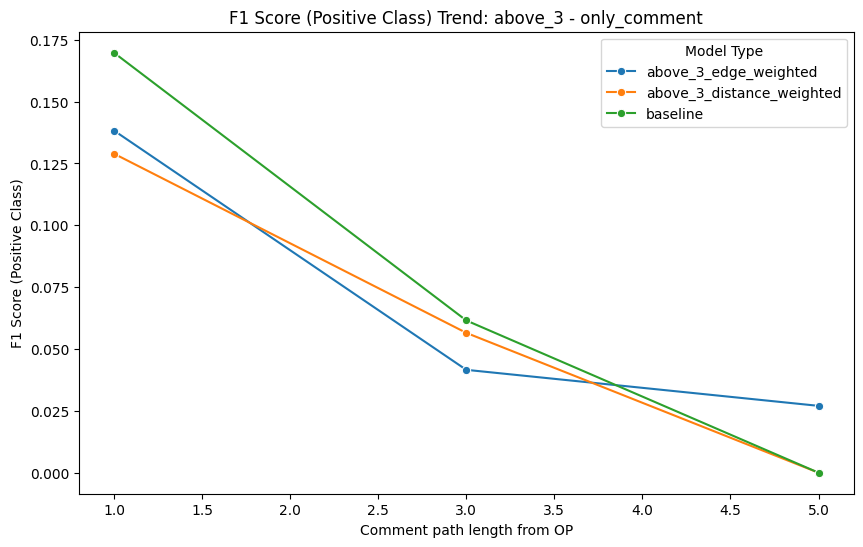

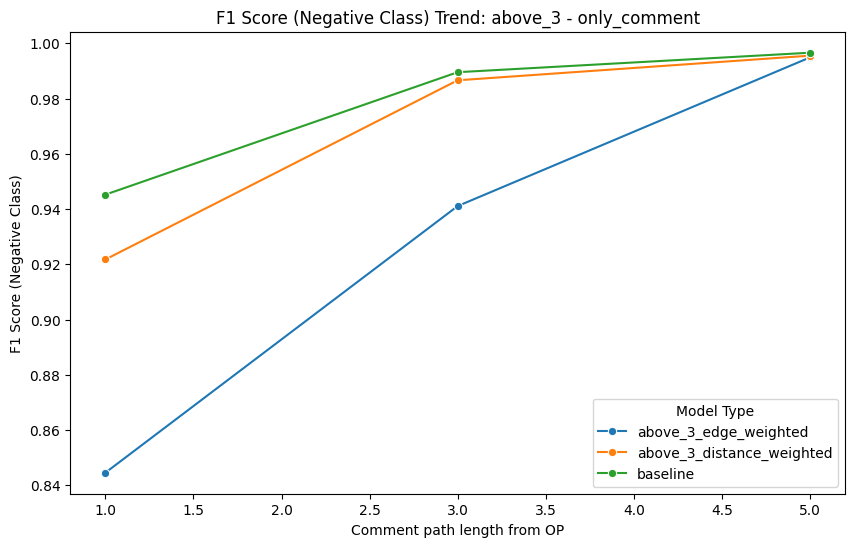

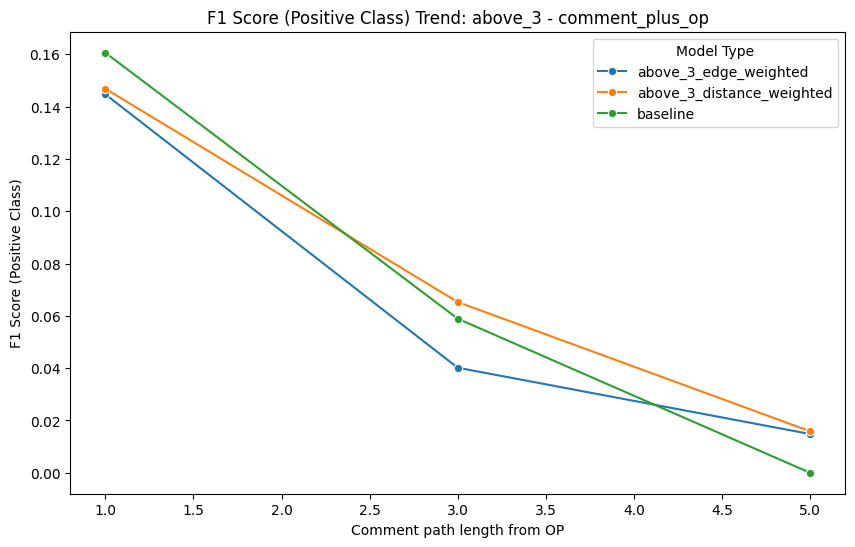

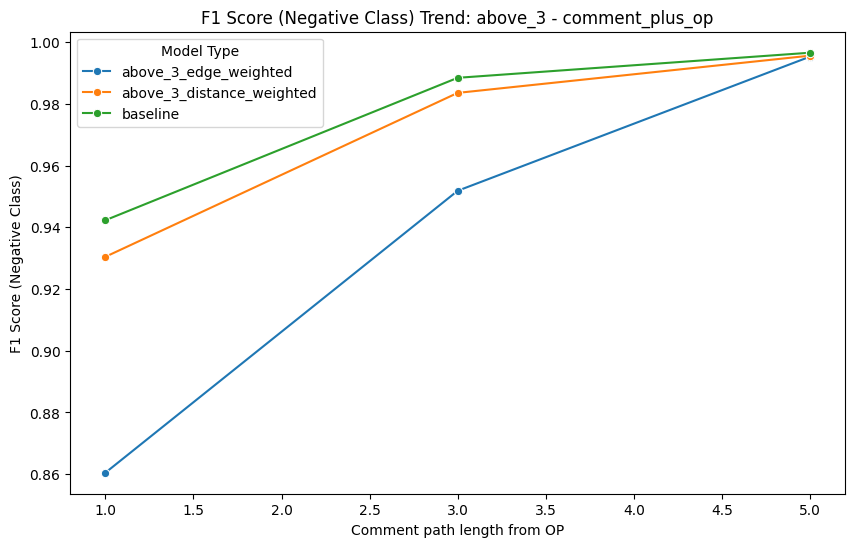

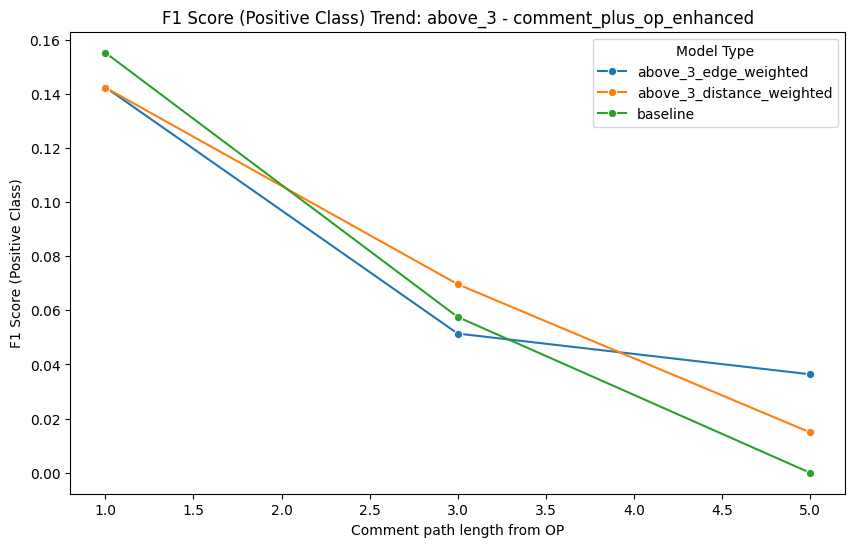

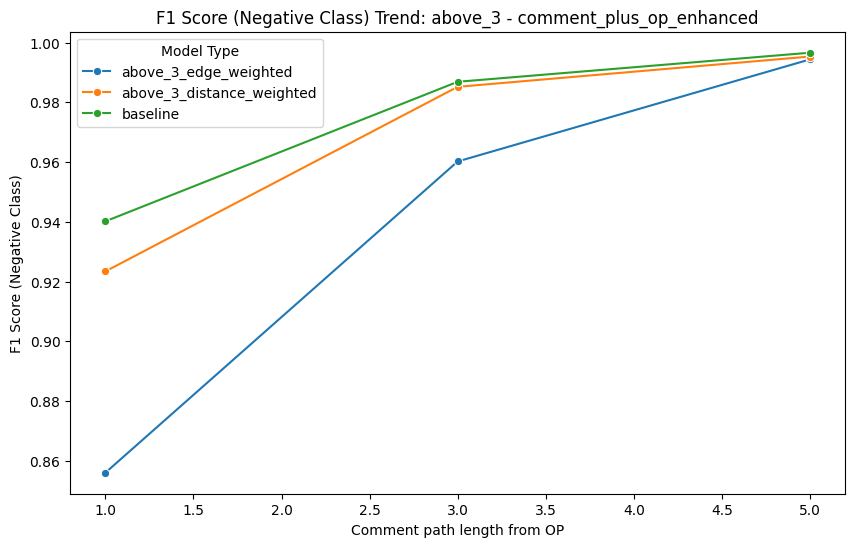

In [64]:
categories = ["above_3"] # "all","pair", 
feature_groups = ["only_comment", "comment_plus_op", "comment_plus_op_enhanced"] # , 

metrics = [
("f1_score_positive", "F1 Score (Positive Class)"),
("f1_score_negative", "F1 Score (Negative Class)"),
]

for category in categories:
    category_results = results_df[(results_df["model_type"].str.contains(category)) | (results_df["model_type"] == 'baseline')]
    for feature_group in feature_groups:
        feature_results = category_results[category_results["config_name"] == feature_group]
        for metric_key, metric_name in metrics:
            plt.figure(figsize=(10, 6))
            sns.lineplot(
                data=feature_results,
                x="distance",
                y=metric_key,
                hue="model_type",
                marker="o"
            )
            plt.title(f"{metric_name} Trend: {category} - {feature_group}")
            plt.xlabel("Comment path length from OP")
            plt.ylabel(metric_name)
            plt.legend(title="Model Type")
            plt.show()
            # plot_path = os.path.join(category_dir, f"{feature_group}_{metric_key}_trend.png")
            # plt.savefig(plot_path)
            # plt.close()

            # print(f"Saved trend plot: {plot_path}")